
# Sistema de Recomendación de Cultivos con Deep Learning

Este sistema implementa un análisis comparativo de tres arquitecturas diferentes
de redes neuronales para la recomendación de cultivos basada en características
del suelo y condiciones climáticas.

Características principales:
- Preprocesamiento avanzado de datos con normalización
- Tres arquitecturas de modelos: DropClassifier, DeepDropoutClassifier, Conv1DClassifier
- Sistema de Early Stopping avanzado con múltiples criterios
- Comparación sistemática de modelos con métricas detalladas
- Motor de inferencia standalone para producción
- Visualizaciones y reportes automáticos

Autores: Alan Anthony Hernandez Perez y Luis Carlos Rico Almada.
Fecha: Mayo de 2025.

In [313]:
%pip install torch pandas numpy matplotlib seaborn scikit-learn tabulate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [314]:
# Verificar dependencias principales
try:
    import sys
    print(f"🐍 Python ejecutable: {sys.executable}")
    print(f"📦 Versión de Python: {sys.version}")
    import os
    import torch
    import time
    import json
    import pickle
    from datetime import datetime
    from collections import deque
    from tabulate import tabulate
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from torch.utils.data import Dataset
    import torch.nn.functional as F
    import torch.nn as nn
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    from torch.utils.data import random_split, DataLoader
    from typing import Union, List, Dict, Tuple, Optional
    import warnings
    print("✅ Todas las dependencias principales están disponibles")
except ImportError as e:
    print(f"❌ Error importando dependencias: {e}")
    print("💡 Instala las dependencias con: pip install torch pandas numpy matplotlib seaborn scikit-learn")

🐍 Python ejecutable: /Library/Developer/CommandLineTools/usr/bin/python3
📦 Versión de Python: 3.9.6 (default, Mar 12 2025, 20:22:46) 
[Clang 17.0.0 (clang-1700.0.13.3)]
✅ Todas las dependencias principales están disponibles



## SECCIÓN 1: ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO DE DATOS


Esta sección se encarga de:
1. Cargar y explorar el dataset de recomendación de cultivos
2. Analizar la distribución de características por cultivo
3. Verificar la calidad y balance de los datos
4. Generar visualizaciones exploratorias

El dataset contiene 7 características numéricas:
- N, P, K: Contenido de nutrientes en el suelo (kg/ha)
- temperature: Temperatura promedio (°C)
- humidity: Humedad relativa (%)
- ph: Nivel de pH del suelo
- rainfall: Precipitación anual (mm)

Y una variable objetivo:
- label: Tipo de cultivo recomendado (22 clases diferentes)


In [315]:
# preprocesamiento

print(f"\n📊 ANÁLISIS EXPLORATORIO DE DATOS")
print(f"{'='*50}")

# Cargar dataset principal
try:
    df = pd.read_csv('Crop_recommendation.csv')
    print(f"✅ Dataset cargado exitosamente")
    print(f"📏 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"🏷️  Columnas: {list(df.columns)}")
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo 'Crop_recommendation.csv'")
    print(f"💡 Asegúrate de que el archivo esté en el directorio actual")
    exit(1)

# Definir características numéricas y obtener cultivos únicos
cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
cultivos = df['label'].unique()

print(f"🌾 Cultivos únicos encontrados: {len(cultivos)}")
print(f"📊 Características a analizar: {cols}")


📊 ANÁLISIS EXPLORATORIO DE DATOS
✅ Dataset cargado exitosamente
📏 Dimensiones: 2200 filas × 8 columnas
🏷️  Columnas: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
🌾 Cultivos únicos encontrados: 22
📊 Características a analizar: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


### VISUALIZACIÓN 1: HISTOGRAMAS POR CULTIVO Y CARACTERÍSTICA

Genera histogramas para cada característica agrupados por tipo de cultivo.
Esto permite identificar:
- Rangos típicos de cada característica para cada cultivo
- Distribuciones normales vs sesgadas
- Posibles outliers o valores atípicos
- Separabilidad entre cultivos

In [316]:
print(f"\n📈 Generando histogramas por cultivo...")

for col in cols:
    print(f"   📊 Procesando característica: {col}")

    n_cultivos = len(cultivos)
    ncols = 3  # Número de columnas en la grilla de subplots
    nrows = (n_cultivos + ncols - 1) // ncols  # Calcular filas necesarias

    # Crear figura con subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    fig.suptitle(f'Distribución de {col} por Cultivo', fontsize=16, fontweight='bold')

    # Generar histograma para cada cultivo
    for i, cultivo in enumerate(cultivos):
        ax = axes[i // ncols, i % ncols]
        subset = df[df['label'] == cultivo]

        # Crear histograma con estilo mejorado
        sns.histplot(subset[col], bins=20, kde=False, color="skyblue",
                    alpha=0.7, ax=ax, stat='density')

        # Configurar subplot
        ax.set_title(f'Cultivo: {cultivo}', fontweight='bold')
        ax.set_xlabel(f'{col}')
        ax.set_ylabel('Densidad')
        ax.grid(True, alpha=0.3)

        # Agregar estadísticas básicas
        mean_val = subset[col].mean()
        std_val = subset[col].std()
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7,
                  label=f'Media: {mean_val:.2f}')
        ax.legend(fontsize=8)

    # Eliminar subplots vacíos
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.show()  # Descomentado para mostrar en entorno interactivo
    plt.close()  # Cerrar para ahorrar memoria


📈 Generando histogramas por cultivo...
   📊 Procesando característica: N
   📊 Procesando característica: P
   📊 Procesando característica: K
   📊 Procesando característica: temperature
   📊 Procesando característica: humidity
   📊 Procesando característica: ph
   📊 Procesando característica: rainfall


### VISUALIZACIÓN 2: BOXPLOTS PARA ANÁLISIS DE DISTRIBUCIONES Y OUTLIERS

Los boxplots permiten identificar:
- Medianas y cuartiles por cultivo
- Outliers (valores atípicos)
- Rango intercuartílico (IQR)
- Comparación visual entre cultivos

In [317]:
print(f"\n📦 Generando boxplots para análisis de outliers...")

for col in cols:
    print(f"   📊 Boxplot para: {col}")

    plt.figure(figsize=(16, 8))

    # Crear boxplot con estilo mejorado
    box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')

    # Configurar gráfico
    plt.title(f'Distribución de {col} por Cultivo', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Tipo de Cultivo', fontsize=12, fontweight='bold')
    plt.ylabel(f'{col}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Agregar estadísticas globales
    global_mean = df[col].mean()
    global_median = df[col].median()
    plt.axhline(global_mean, color='red', linestyle='--', alpha=0.7,
               label=f'Media global: {global_mean:.2f}')
    plt.axhline(global_median, color='blue', linestyle='--', alpha=0.7,
               label=f'Mediana global: {global_median:.2f}')
    plt.legend()

    plt.tight_layout()
    # plt.show()  # Descomentado para mostrar en entorno interactivo
    plt.close()  # Cerrar para ahorrar memoria


📦 Generando boxplots para análisis de outliers...
   📊 Boxplot para: N
   📊 Boxplot para: P
   📊 Boxplot para: K


/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


   📊 Boxplot para: temperature
   📊 Boxplot para: humidity
   📊 Boxplot para: ph


/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')
/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


   📊 Boxplot para: rainfall


/var/folders/tj/xf_gm8xx5m3gjs50qh0fqy9c0000gn/T/ipykernel_71689/759716857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='label', y=col, data=df, palette='Set3')


### VERIFICACIÓN DE CALIDAD DE DATOS

Esta sección verifica:
1. Presencia de valores nulos o faltantes
2. Balance de clases en el dataset
3. Consistencia de los datos
4. Estadísticas descriptivas básicas

In [318]:
print(f"\n🔍 VERIFICACIÓN DE CALIDAD DE DATOS")
print(f"{'='*50}")

# 1. Verificar valores nulos
print(f"\n📋 Análisis de valores nulos:")
valores_nulos = df.isnull().sum()
print(valores_nulos)

if valores_nulos.sum() == 0:
    print("✅ No se encontraron valores nulos en el dataset")
else:
    print(f"⚠️ Se encontraron {valores_nulos.sum()} valores nulos")
    print("💡 Será necesario aplicar técnicas de imputación")

# 2. Verificar balance de clases
print(f"\n⚖️ Análisis de balance de clases:")
distribucion_cultivos = df['label'].value_counts().sort_index()
print(distribucion_cultivos)

# Calcular estadísticas de balance
min_samples = distribucion_cultivos.min()
max_samples = distribucion_cultivos.max()
mean_samples = distribucion_cultivos.mean()
std_samples = distribucion_cultivos.std()

print(f"\n📊 Estadísticas de distribución:")
print(f"   • Mínimo de muestras por clase: {min_samples}")
print(f"   • Máximo de muestras por clase: {max_samples}")
print(f"   • Promedio de muestras por clase: {mean_samples:.1f}")
print(f"   • Desviación estándar: {std_samples:.1f}")
print(f"   • Ratio max/min: {max_samples/min_samples:.2f}")

# Evaluar balance
if std_samples < mean_samples * 0.1:  # Menos del 10% de variación
    print("✅ Dataset bien balanceado")
elif std_samples < mean_samples * 0.2:  # Menos del 20% de variación
    print("⚠️ Dataset moderadamente balanceado")
else:
    print("❌ Dataset desbalanceado - considerar técnicas de balanceo")

# 3. Información general del dataset
print(f"\n📈 Información general del dataset:")
print(f"   • Total de muestras: {len(df):,}")
print(f"   • Número de características: {len(cols)}")
print(f"   • Número de clases (cultivos): {df['label'].nunique()}")
print(f"   • Cultivos disponibles: {sorted(df['label'].unique())}")

# 4. Estadísticas descriptivas
print(f"\n📊 Estadísticas descriptivas de características:")
estadisticas = df[cols].describe()
print(estadisticas.round(2))


🔍 VERIFICACIÓN DE CALIDAD DE DATOS

📋 Análisis de valores nulos:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
✅ No se encontraron valores nulos en el dataset

⚖️ Análisis de balance de clases:
label
apple          100
banana         100
blackgram      100
chickpea       100
coconut        100
coffee         100
cotton         100
grapes         100
jute           100
kidneybeans    100
lentil         100
maize          100
mango          100
mothbeans      100
mungbean       100
muskmelon      100
orange         100
papaya         100
pigeonpeas     100
pomegranate    100
rice           100
watermelon     100
Name: count, dtype: int64

📊 Estadísticas de distribución:
   • Mínimo de muestras por clase: 100
   • Máximo de muestras por clase: 100
   • Promedio de muestras por clase: 100.0
   • Desviación estándar: 0.0
   • Ratio max/min: 1.00
✅ Dataset bien balanceado

📈 Información ge

In [319]:
class CropDataset(Dataset):
    def __init__(self, csv_path, export_path=None):
        df = pd.read_csv(csv_path)

        self.feature_columns = df.columns[:-1]
        self.label_column = df.columns[-1]

        # Codificar etiquetas a números

        unique_labels = df[self.label_column].unique()
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

        #generacion de la columna de label encoded
        df['encoded_label'] = df[self.label_column].map(self.label_mapping)

        for crop, idx in self.label_mapping.items():
            print(f"Label: {crop}, Encoded: {idx}")

        # Normalización global
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[self.feature_columns])
        normalized_df = pd.DataFrame(scaled_features, columns=self.feature_columns)
        normalized_df['label'] = df[self.label_column]
        normalized_df['encoded_label'] = df['encoded_label']

        # Mezclar datos (shuffle)
        normalized_df = normalized_df.sample(frac=1).reset_index(drop=True)

        # Guardar CSV si se especifica ruta
        if export_path:
            normalized_df.to_csv(export_path, index=False)
            print(f"[INFO] CSV exportado en: {export_path}")

        # Convertir a tensores
        self.X = torch.tensor(normalized_df[self.feature_columns].values, dtype=torch.float32)
        self.y = torch.tensor(normalized_df['encoded_label'].values, dtype=torch.long)

        self.num_classes = len(unique_labels)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def get_x_y(self):
        return self.X, self.y

    def get_label_mapping(self):
        return self.label_mapping

In [320]:
dataset = CropDataset("Crop_recommendation.csv", export_path="Crop_recommendation_normalized.csv")

Label: rice, Encoded: 0
Label: maize, Encoded: 1
Label: chickpea, Encoded: 2
Label: kidneybeans, Encoded: 3
Label: pigeonpeas, Encoded: 4
Label: mothbeans, Encoded: 5
Label: mungbean, Encoded: 6
Label: blackgram, Encoded: 7
Label: lentil, Encoded: 8
Label: pomegranate, Encoded: 9
Label: banana, Encoded: 10
Label: mango, Encoded: 11
Label: grapes, Encoded: 12
Label: watermelon, Encoded: 13
Label: muskmelon, Encoded: 14
Label: apple, Encoded: 15
Label: orange, Encoded: 16
Label: papaya, Encoded: 17
Label: coconut, Encoded: 18
Label: cotton, Encoded: 19
Label: jute, Encoded: 20
Label: coffee, Encoded: 21
[INFO] CSV exportado en: Crop_recommendation_normalized.csv


In [321]:
X, y = dataset[0]
print("Features (X):", X)
print("Etiqueta y", y)
print("Forma de y:", y.shape)

Features (X): tensor([-0.3130,  0.6864,  0.5500, -1.1156, -2.5118,  2.1537, -0.6244])
Etiqueta y tensor(2)
Forma de y: torch.Size([])


**Genertacion del dataSet**

In [322]:
x, y = dataset.get_x_y()
#dataset reunido

dataset_tratado = torch.utils.data.TensorDataset(x, y)

# Dividir el dataset en entrenamiento y prueba
#70% entrenamiento, 30% prueba
train, val = random_split(dataset_tratado, [int(len(dataset_tratado) * 0.6), int(len(dataset_tratado) * 0.4)])
#genera los dataloaders
#ademas de aplicar el shuffle, para utilizar el teorema de limite central
train = DataLoader(train, batch_size=32, shuffle=True)
val= DataLoader(val, batch_size=32, shuffle=True)

In [323]:
def earlyStopping(val_losses, train_losses, best_moving_avg_loss,
                  patience, epochs_without_improvement, window_size, model, model_name):
    """
    Revisa si debe activarse early stopping basado en la media móvil del validation loss.

    Retorna:
        stop (bool): True si se debe detener el entrenamiento
        best_moving_avg_loss (float): actualizado si hay mejora
        epochs_without_improvement (int): actualizado
    """
    stop = False
    if len(val_losses) >= window_size:
        moving_avg = sum(val_losses[-window_size:]) / window_size
        print("Media móvil del loss de validación:", moving_avg)

        if moving_avg < best_moving_avg_loss:
            best_moving_avg_loss = moving_avg
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            print("Nueva mejor media móvil. Modelo guardado.")
        else:
            epochs_without_improvement += 1
            print("No hubo mejora en el loss de validación.")
            print("Épocas sin mejora:", epochs_without_improvement, "de", patience)
            if epochs_without_improvement >= patience:
                print("Detención temprana activada por falta de mejora.")
                stop = True

    return stop, best_moving_avg_loss, epochs_without_improvement

### Sistema Avanzado de Early Stopping para Modelos de Deep Learning

Este módulo implementa un sistema de parada temprana mejorado con:
- Múltiples criterios de parada (loss, accuracy, F1-score)
- Parámetros adaptativos
- Restauración automática del mejor modelo
- Documentación detallada de decisiones
- Análisis de tendencias

In [324]:
class AdvancedEarlyStopping:
    """
    Sistema avanzado de Early Stopping con múltiples criterios de evaluación.

    Características:
    - Múltiples métricas de monitoreo (loss, accuracy, F1-score)
    - Ventanas móviles adaptativas
    - Detección de plateau y overfitting
    - Guardado automático del mejor modelo
    - Logging detallado de decisiones
    """

    def __init__(self,
                 patience=15,
                 min_delta=1e-4,
                 window_size=7,
                 restore_best_weights=True,
                 monitor_metrics=['val_loss', 'val_accuracy'],
                 mode='auto',
                 factor=0.1,
                 adaptive_patience=True,
                 verbose=True,
                 save_dir='checkpoints'):
        """
        Inicializa el sistema de Early Stopping avanzado.

        Args:
            patience (int): Número de épocas sin mejora antes de parar
            min_delta (float): Cambio mínimo para considerar una mejora
            window_size (int): Tamaño de ventana para media móvil
            restore_best_weights (bool): Restaurar pesos del mejor modelo
            monitor_metrics (list): Métricas a monitorear ['val_loss', 'val_accuracy', 'val_f1']
            mode (str): 'min', 'max' o 'auto' para cada métrica
            factor (float): Factor de reducción para patience adaptativo
            adaptive_patience (bool): Ajustar patience dinámicamente
            verbose (bool): Imprimir información detallada
            save_dir (str): Directorio para guardar checkpoints
        """
        self.patience = patience
        self.original_patience = patience
        self.min_delta = min_delta
        self.window_size = window_size
        self.restore_best_weights = restore_best_weights
        self.monitor_metrics = monitor_metrics
        self.factor = factor
        self.adaptive_patience = adaptive_patience
        self.verbose = verbose
        self.save_dir = save_dir

        # Crear directorio de guardado
        os.makedirs(save_dir, exist_ok=True)

        # Determinar modo para cada métrica
        self.modes = {}
        for metric in monitor_metrics:
            if mode == 'auto':
                if 'loss' in metric.lower():
                    self.modes[metric] = 'min'
                else:
                    self.modes[metric] = 'max'
            else:
                self.modes[metric] = mode

        # Inicializar variables de estado
        self.reset()

        # Logging
        self.decision_log = []
        self.start_time = datetime.now()

    def reset(self):
        """Reinicia el estado del early stopping."""
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None
        self.best_epoch = 0

        # Mejores valores para cada métrica
        self.best_values = {}
        for metric in self.monitor_metrics:
            if self.modes[metric] == 'min':
                self.best_values[metric] = np.inf
            else:
                self.best_values[metric] = -np.inf

        # Historial de métricas
        self.history = {metric: deque(maxlen=self.window_size * 2)
                       for metric in self.monitor_metrics}

        # Contadores específicos por métrica
        self.metric_wait = {metric: 0 for metric in self.monitor_metrics}

        # Detección de plateau
        self.plateau_count = 0
        self.overfitting_detected = False

    def _is_improvement(self, current_value, best_value, mode):
        """Determina si hay mejora en una métrica."""
        if mode == 'min':
            return current_value < (best_value - self.min_delta)
        else:
            return current_value > (best_value + self.min_delta)

    def _calculate_moving_average(self, metric):
        """Calcula la media móvil de una métrica."""
        if len(self.history[metric]) < self.window_size:
            return None
        return np.mean(list(self.history[metric])[-self.window_size:])

    def _detect_plateau(self, metric):
        """Detecta si una métrica está en plateau."""
        if len(self.history[metric]) < self.window_size * 2:
            return False

        recent_values = list(self.history[metric])[-self.window_size:]
        older_values = list(self.history[metric])[-self.window_size*2:-self.window_size]

        recent_std = np.std(recent_values)
        older_std = np.std(older_values)

        # Plateau si la variabilidad reciente es muy baja
        return recent_std < self.min_delta and recent_std < older_std * 0.5

    def _detect_overfitting(self, train_loss, val_loss):
        """Detecta overfitting comparando train y validation loss."""
        if train_loss is None or val_loss is None:
            return False

        # Overfitting si val_loss aumenta mientras train_loss disminuye
        gap = val_loss - train_loss
        return gap > 0.1 and len(self.history.get('val_loss', [])) > 10

    def _adaptive_patience_adjustment(self):
        """Ajusta la patience dinámicamente basado en el progreso."""
        if not self.adaptive_patience:
            return

        # Aumentar patience si se detecta mejora lenta pero consistente
        if self.wait > self.patience * 0.7:
            recent_improvements = sum(1 for metric in self.monitor_metrics
                                    if self.metric_wait[metric] < self.patience * 0.3)

            if recent_improvements > 0:
                self.patience = min(self.patience + 5, self.original_patience * 2)
                if self.verbose:
                    print(f"📈 Patience aumentada a {self.patience} (mejora lenta detectada)")

    def __call__(self, epoch, metrics, model=None, model_name="model"):
        """
        Evalúa si se debe detener el entrenamiento.

        Args:
            epoch (int): Época actual
            metrics (dict): Diccionario con métricas {'val_loss': 0.5, 'val_accuracy': 0.9, ...}
            model (torch.nn.Module): Modelo para guardar
            model_name (str): Nombre del modelo

        Returns:
            bool: True si se debe detener el entrenamiento
        """
        current_decision = {
            'epoch': epoch,
            'timestamp': datetime.now().isoformat(),
            'metrics': metrics.copy(),
            'improvements': {},
            'decision': 'continue'
        }

        # Actualizar historial
        for metric in self.monitor_metrics:
            if metric in metrics:
                self.history[metric].append(metrics[metric])

        # Evaluar cada métrica
        any_improvement = False
        improvement_details = {}

        for metric in self.monitor_metrics:
            if metric not in metrics:
                continue

            current_value = metrics[metric]
            best_value = self.best_values[metric]
            mode = self.modes[metric]

            # Verificar mejora
            if self._is_improvement(current_value, best_value, mode):
                self.best_values[metric] = current_value
                self.metric_wait[metric] = 0
                any_improvement = True
                improvement_details[metric] = {
                    'improved': True,
                    'previous_best': best_value,
                    'new_best': current_value,
                    'improvement': abs(current_value - best_value)
                }

                if self.verbose:
                    print(f"✅ Mejora en {metric}: {best_value:.6f} → {current_value:.6f}")
            else:
                self.metric_wait[metric] += 1
                improvement_details[metric] = {
                    'improved': False,
                    'current': current_value,
                    'best': best_value,
                    'wait_count': self.metric_wait[metric]
                }

        current_decision['improvements'] = improvement_details

        # Guardar mejor modelo si hay mejora
        if any_improvement and model is not None:
            self.best_weights = model.state_dict().copy()
            self.best_epoch = epoch

            # Guardar checkpoint
            checkpoint_path = os.path.join(self.save_dir, f'best_{model_name}_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'metrics': metrics,
                'best_values': self.best_values
            }, checkpoint_path)

            if self.verbose:
                print(f"💾 Modelo guardado en {checkpoint_path}")

        # Actualizar contador general
        if any_improvement:
            self.wait = 0
        else:
            self.wait += 1

        # Detección de plateau y overfitting
        plateau_detected = any(self._detect_plateau(metric) for metric in self.monitor_metrics
                              if metric in metrics)

        train_loss = metrics.get('train_loss')
        val_loss = metrics.get('val_loss')
        overfitting = self._detect_overfitting(train_loss, val_loss)

        if plateau_detected:
            self.plateau_count += 1
            if self.verbose and self.plateau_count == 1:
                print("⚠️  Plateau detectado en las métricas")

        if overfitting and not self.overfitting_detected:
            self.overfitting_detected = True
            if self.verbose:
                print("⚠️  Posible overfitting detectado")

        # Ajuste adaptativo de patience
        self._adaptive_patience_adjustment()

        # Decisión de parada
        stop_training = False
        stop_reason = None

        if self.wait >= self.patience:
            stop_training = True
            stop_reason = f"Patience agotada ({self.patience} épocas sin mejora)"

        elif overfitting and self.wait >= self.patience // 2:
            stop_training = True
            stop_reason = "Overfitting detectado con patience parcial"

        elif plateau_detected and self.plateau_count >= self.patience // 3:
            stop_training = True
            stop_reason = "Plateau prolongado detectado"

        if stop_training:
            self.stopped_epoch = epoch
            current_decision['decision'] = 'stop'
            current_decision['stop_reason'] = stop_reason

            if self.verbose:
                print(f"\n🛑 Early Stopping activado en época {epoch}")
                print(f"📋 Razón: {stop_reason}")
                print(f"🏆 Mejor época: {self.best_epoch}")
                print(f"📊 Mejores métricas: {self.best_values}")

            # Restaurar mejor modelo
            if self.restore_best_weights and self.best_weights is not None and model is not None:
                model.load_state_dict(self.best_weights)
                if self.verbose:
                    print(f"🔄 Modelo restaurado a la época {self.best_epoch}")

        # Logging de la decisión
        self.decision_log.append(current_decision)

        # Información periódica
        if self.verbose and epoch % 10 == 0:
            self._print_status(epoch)

        return stop_training

    def _print_status(self, epoch):
        """Imprime el estado actual del early stopping."""
        print(f"\n📊 Estado Early Stopping (Época {epoch}):")
        print(f"   ⏳ Épocas sin mejora: {self.wait}/{self.patience}")
        print(f"   🏆 Mejor época: {self.best_epoch}")

        for metric, value in self.best_values.items():
            if metric in self.monitor_metrics:
                moving_avg = self._calculate_moving_average(metric)
                if moving_avg is not None:
                    print(f"   📈 {metric}: {value:.6f} (MA: {moving_avg:.6f})")
                else:
                    print(f"   📈 {metric}: {value:.6f}")

    def get_summary(self):
        """Retorna un resumen del proceso de early stopping."""
        total_time = datetime.now() - self.start_time

        summary = {
            'total_epochs': len(self.decision_log),
            'stopped_epoch': self.stopped_epoch,
            'best_epoch': self.best_epoch,
            'best_metrics': self.best_values,
            'total_time': str(total_time),
            'patience_used': self.patience,
            'original_patience': self.original_patience,
            'plateau_detected': self.plateau_count > 0,
            'overfitting_detected': self.overfitting_detected,
            'final_wait_count': self.wait
        }

        return summary

    def save_log(self, filepath):
        """Guarda el log de decisiones en un archivo JSON."""
        log_data = {
            'summary': self.get_summary(),
            'decisions': self.decision_log,
            'config': {
                'patience': self.original_patience,
                'min_delta': self.min_delta,
                'window_size': self.window_size,
                'monitor_metrics': self.monitor_metrics,
                'modes': self.modes,
                'adaptive_patience': self.adaptive_patience
            }
        }

        with open(filepath, 'w') as f:
            json.dump(log_data, f, indent=2, default=str)

        print(f"📄 Log guardado en {filepath}")

    def plot_metrics_history(self, save_path=None):
        """Genera gráficas del historial de métricas."""
        if not self.decision_log:
            print("No hay datos para graficar")
            return

        # Extraer datos
        epochs = [d['epoch'] for d in self.decision_log]

        # Crear subplots
        n_metrics = len(self.monitor_metrics)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics))
        if n_metrics == 1:
            axes = [axes]

        for i, metric in enumerate(self.monitor_metrics):
            values = []
            moving_avgs = []

            for d in self.decision_log:
                if metric in d['metrics']:
                    values.append(d['metrics'][metric])
                else:
                    values.append(None)

            # Calcular medias móviles
            for j in range(len(values)):
                if j >= self.window_size - 1:
                    window_values = [v for v in values[j-self.window_size+1:j+1] if v is not None]
                    if window_values:
                        moving_avgs.append(np.mean(window_values))
                    else:
                        moving_avgs.append(None)
                else:
                    moving_avgs.append(None)

            # Graficar
            ax = axes[i]

            # Valores originales
            valid_epochs = [e for e, v in zip(epochs, values) if v is not None]
            valid_values = [v for v in values if v is not None]
            ax.plot(valid_epochs, valid_values, 'o-', alpha=0.7, label=f'{metric}')

            # Media móvil
            valid_ma_epochs = [e for e, v in zip(epochs, moving_avgs) if v is not None]
            valid_ma_values = [v for v in moving_avgs if v is not None]
            if valid_ma_values:
                ax.plot(valid_ma_epochs, valid_ma_values, '-', linewidth=2,
                       label=f'{metric} (MA-{self.window_size})')

            # Marcar mejor época
            if self.best_epoch > 0:
                ax.axvline(x=self.best_epoch, color='green', linestyle='--',
                          alpha=0.7, label=f'Mejor época ({self.best_epoch})')

            # Marcar época de parada
            if self.stopped_epoch > 0:
                ax.axvline(x=self.stopped_epoch, color='red', linestyle='--',
                          alpha=0.7, label=f'Parada ({self.stopped_epoch})')

            ax.set_xlabel('Época')
            ax.set_ylabel(metric)
            ax.set_title(f'Evolución de {metric}')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Gráficas guardadas en {save_path}")

        plt.show()

In [325]:
def calculate_validation_metrics(model, val_loader, device, n_classes):
    """
    Calcula métricas de validación para usar con Early Stopping.

    Returns:
        dict: Métricas calculadas
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    # Calcular métricas
    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total

    # Calcular F1-score macro
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return {
        'val_loss': avg_loss,
        'val_accuracy': accuracy,
        'val_f1': f1
    }

In [326]:
def train_model(model, model_name, train_loader, val_loader, device, num_epochs=1000, lr=0.001):
    """
    Función para entrenar un modelo con early stopping avanzado
    """
    print(f"\n{'='*50}")
    print(f"Entrenando modelo: {model_name}")
    print(f"{'='*50}")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Configurar Early Stopping avanzado
    early_stopping = AdvancedEarlyStopping(
        patience=20,                    # Aumentado para mejor convergencia
        min_delta=1e-5,                # Más sensible a pequeñas mejoras
        window_size=10,                # Ventana más grande para estabilidad
        restore_best_weights=True,
        monitor_metrics=['val_loss', 'val_accuracy', 'val_f1'],
        adaptive_patience=True,
        verbose=True,
        save_dir=f'checkpoints_{model_name}'
    )

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    print(f"🚀 Iniciando entrenamiento con Early Stopping avanzado")
    print(f"📊 Monitoreando: {early_stopping.monitor_metrics}")
    print(f"⏳ Patience inicial: {early_stopping.patience}")
    print(f"🎯 Min delta: {early_stopping.min_delta}")
    print(f"📏 Window size: {early_stopping.window_size}")

    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        epoch_train_loss = 0
        num_batches = 0

        for train_batch in train_loader:
            x, y = train_batch
            if torch.cuda.is_available():
                x = x.cuda(0)
                y = y.cuda(0)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = nn.functional.cross_entropy(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            num_batches += 1

        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)

        # Validación con métricas completas
        val_metrics = calculate_validation_metrics(model, val_loader, device, n_classes=22)
        val_metrics['train_loss'] = avg_train_loss  # Agregar train loss para detección de overfitting

        val_losses.append(val_metrics['val_loss'])
        val_accuracies.append(val_metrics['val_accuracy'])
        val_f1_scores.append(val_metrics['val_f1'])

        # Mostrar progreso cada 5 épocas
        if epoch % 5 == 0:
            print(f"Época {epoch + 1:3d}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Val Loss: {val_metrics['val_loss']:.6f} | "
                  f"Val Acc: {val_metrics['val_accuracy']:.4f} | "
                  f"Val F1: {val_metrics['val_f1']:.4f}")

        # Evaluar Early Stopping
        should_stop = early_stopping(epoch, val_metrics, model, model_name)

        if should_stop:
            print(f"\n✅ Entrenamiento completado por Early Stopping")
            break

    # Obtener resumen del early stopping
    summary = early_stopping.get_summary()
    print(f"\n📋 RESUMEN DEL ENTRENAMIENTO:")
    print(f"   🏁 Épocas totales: {summary['total_epochs']}")
    print(f"   🏆 Mejor época: {summary['best_epoch']}")
    print(f"   ⏱️  Tiempo total: {summary['total_time']}")
    print(f"   📊 Mejores métricas:")
    for metric, value in summary['best_metrics'].items():
        print(f"      {metric}: {value:.6f}")

    # Guardar log detallado
    log_path = f"training_log_{model_name}.json"
    early_stopping.save_log(log_path)

    # Generar gráficas del entrenamiento
    early_stopping.plot_metrics_history(f"training_history_{model_name}.png")

    # Truncar listas a la mejor época para consistencia
    best_epoch = summary['best_epoch']
    if best_epoch > 0 and best_epoch < len(train_losses):
        train_losses = train_losses[:best_epoch + 1]
        val_losses = val_losses[:best_epoch + 1]
        val_accuracies = val_accuracies[:best_epoch + 1]
        val_f1_scores = val_f1_scores[:best_epoch + 1]

    return model, train_losses, val_losses, {
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores,
        'early_stopping_summary': summary
    }

In [327]:
def evaluate_model(model, val_loader, device, n_classes, label_mapping):
    """
    Función para evaluar un modelo y calcular métricas
    """
    model.eval()
    matriz_confusion = np.zeros((n_classes, n_classes))

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            if torch.cuda.is_available():
                x_batch = x_batch.cuda(0)
                y_batch = y_batch.cuda(0)
            y_pred = model(x_batch)
            preds = torch.argmax(y_pred, dim=1)
            for t, p in zip(y_batch.view(-1), preds.view(-1)):
                matriz_confusion[t.long(), p.long()] += 1

    # Calcular métricas por clase
    precision = []
    recall = []
    f1_score = []
    accuracy_por_clase = []

    for i in range(n_classes):
        TP = matriz_confusion[i, i]
        FP = matriz_confusion[:, i].sum() - TP
        FN = matriz_confusion[i, :].sum() - TP
        TN = matriz_confusion.sum() - (TP + FP + FN)

        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score_i = 2 * ((precision_i * recall_i) / (precision_i + recall_i)) if (precision_i + recall_i) > 0 else 0
        accuracy_i = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_score_i)
        accuracy_por_clase.append(accuracy_i)

    # Métricas globales
    precision_global = np.mean(precision)
    recall_global = np.mean(recall)
    f1_score_global = 2 * (precision_global * recall_global) / (precision_global + recall_global) if (precision_global + recall_global) > 0 else 0
    accuracy_global = np.mean(accuracy_por_clase)

    return {
        'precision_global': precision_global,
        'recall_global': recall_global,
        'f1_score_global': f1_score_global,
        'accuracy_global': accuracy_global,
        'matriz_confusion': matriz_confusion,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy_por_clase': accuracy_por_clase
    }

In [328]:
def predict_crop_with_device(model, features, label_mapping, device):
    """
    Función para hacer predicciones con un modelo entrenado

    Args:
        model: modelo entrenado
        features: tensor con las características [N, P, K, temperature, humidity, ph, rainfall]
        label_mapping: diccionario de mapeo de etiquetas
        device: dispositivo (CPU/GPU)

    Returns:
        predicted_crop: nombre del cultivo predicho
        probabilities: probabilidades para cada clase
    """
    model.eval()
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}

    with torch.no_grad():
        if isinstance(features, list):
            features = torch.tensor(features, dtype=torch.float32)

        if len(features.shape) == 1:
            features = features.unsqueeze(0)  # Agregar dimensión de batch

        features = features.to(device)

        # Hacer predicción
        outputs = model(features)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1)

        predicted_crop = inverse_label_mapping[predicted_class.item()]

        return predicted_crop, probabilities.cpu().numpy()[0]

In [329]:
#Generacion de los modelos

class DropClassifier(torch.nn.Module):

    def __init__(self, n_classes, input_size=7, hidden_size=64):
      super(DropClassifier, self).__init__()

      self.encoder = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_classes)
      )


    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

In [330]:
class DeepDropoutClassifier(torch.nn.Module):
    """
    Modelo 2: Red neuronal más profunda con Dropout y Batch Normalization
    """
    def __init__(self, n_classes, input_size=7, hidden_sizes=[128, 256, 128, 64], dropout_rate=0.3):
        super(DeepDropoutClassifier, self).__init__()

        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            # Capa lineal
            layers.append(nn.Linear(prev_size, hidden_size))
            # Batch normalization
            layers.append(nn.BatchNorm1d(hidden_size))
            # Activación
            layers.append(nn.ReLU())
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, n_classes))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_hat = self.encoder(x)
        return y_hat

In [331]:
class Conv1DClassifier(torch.nn.Module):
    """
    Modelo 3: Red neuronal con capas convolucionales 1D
    """
    def __init__(self, n_classes, input_size=7, conv_channels=[16, 32, 64], kernel_size=3):
        super(Conv1DClassifier, self).__init__()

        # Capas convolucionales 1D
        conv_layers = []
        in_channels = 1

        for out_channels in conv_channels:
            conv_layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*conv_layers)

        # Calcular el tamaño después de las convoluciones
        # Para input_size=7 y padding='same', el tamaño se mantiene
        conv_output_size = input_size * conv_channels[-1]

        # Capas fully connected
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )

        # Global Average Pooling como alternativa
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_alternative = nn.Sequential(
            nn.Linear(conv_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)
        # Reshape para conv1d: (batch_size, channels, sequence_length)
        x = x.view(batch_size, 1, -1)

        # Aplicar capas convolucionales
        x = self.conv_layers(x)

        # Opción 1: Flatten y FC layers
        # x = x.view(batch_size, -1)
        # y_hat = self.fc_layers(x)

        # Opción 2: Global Average Pooling (más eficiente)
        x = self.global_avg_pool(x)  # (batch_size, channels, 1)
        x = x.view(batch_size, -1)   # (batch_size, channels)
        y_hat = self.fc_alternative(x)

        return y_hat

### Módulo de Comparación Avanzada de Modelos

Este módulo proporciona herramientas para comparar múltiples arquitecturas de modelos
de deep learning, incluyendo análisis de rendimiento, overfitting, tiempo de convergencia
y recomendaciones finales.

In [332]:
class ModelComparator:
    """
    Clase para comparar múltiples modelos de manera sistemática.

    Características:
    - Entrenamiento paralelo de múltiples modelos
    - Análisis de métricas de rendimiento
    - Detección de overfitting
    - Análisis de tiempo de convergencia
    - Generación de reportes comparativos
    - Recomendaciones automáticas
    """

    def __init__(self, models_dict, device, save_dir="comparison_results"):
        """
        Inicializa el comparador de modelos.

        Args:
            models_dict (dict): Diccionario con modelos {nombre: modelo}
            device (torch.device): Dispositivo para entrenamiento
            save_dir (str): Directorio para guardar resultados
        """
        self.models = models_dict
        self.device = device
        self.save_dir = save_dir
        self.results = {}
        self.training_history = {}
        self.timing_data = {}

        # Crear directorio de resultados
        os.makedirs(save_dir, exist_ok=True)

        print(f"🔬 ModelComparator inicializado")
        print(f"📊 Modelos a comparar: {list(models_dict.keys())}")
        print(f"💾 Resultados en: {save_dir}")

    def train_and_compare(self, train_loader, val_loader, train_function,
                         num_epochs=300, lr=0.001, **train_kwargs):
        """
        Entrena todos los modelos y recopila métricas de comparación.

        Args:
            train_loader: DataLoader de entrenamiento
            val_loader: DataLoader de validación
            train_function: Función de entrenamiento a usar
            num_epochs (int): Número máximo de épocas
            lr (float): Learning rate
            **train_kwargs: Argumentos adicionales para la función de entrenamiento

        Returns:
            dict: Resultados de comparación
        """
        print(f"\n🚀 INICIANDO COMPARACIÓN DE MODELOS")
        print(f"{'='*60}")

        for model_name, model in self.models.items():
            print(f"\n🔄 Entrenando modelo: {model_name}")
            print(f"{'─'*40}")

            # Medir tiempo de entrenamiento
            start_time = time.time()
            start_datetime = datetime.now()

            # Entrenar modelo
            try:
                result = train_function(
                    model, model_name, train_loader, val_loader,
                    self.device, num_epochs=num_epochs, lr=lr, **train_kwargs
                )

                # Desempaquetar resultados según el formato
                if len(result) == 4:
                    trained_model, train_losses, val_losses, extra_data = result
                    early_stopping_summary = extra_data.get('early_stopping_summary', {})
                else:
                    trained_model, train_losses, val_losses = result
                    early_stopping_summary = {}

                # Calcular tiempo de entrenamiento
                end_time = time.time()
                training_time = end_time - start_time

                # Guardar datos de timing
                self.timing_data[model_name] = {
                    'training_time_seconds': training_time,
                    'training_time_formatted': self._format_time(training_time),
                    'start_datetime': start_datetime.isoformat(),
                    'end_datetime': datetime.now().isoformat(),
                    'epochs_trained': len(train_losses),
                    'time_per_epoch': training_time / len(train_losses) if train_losses else 0
                }

                # Guardar historial de entrenamiento
                self.training_history[model_name] = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'early_stopping_summary': early_stopping_summary
                }

                # Evaluar modelo
                metrics = self._evaluate_model(trained_model, val_loader, model_name)

                # Análisis de overfitting
                overfitting_analysis = self._analyze_overfitting(train_losses, val_losses)

                # Análisis de convergencia
                convergence_analysis = self._analyze_convergence(train_losses, val_losses)

                # Compilar resultados
                self.results[model_name] = {
                    'model': trained_model,
                    'metrics': metrics,
                    'overfitting_analysis': overfitting_analysis,
                    'convergence_analysis': convergence_analysis,
                    'timing': self.timing_data[model_name],
                    'early_stopping': early_stopping_summary
                }

                print(f"✅ {model_name} completado en {self._format_time(training_time)}")

            except Exception as e:
                print(f"❌ Error entrenando {model_name}: {e}")
                self.results[model_name] = {'error': str(e)}

        # Generar análisis comparativo
        comparison_results = self._generate_comparison_analysis()

        # Guardar resultados
        self._save_results()

        return comparison_results

    def _evaluate_model(self, model, val_loader, model_name):
        """
        Evalúa un modelo y calcula métricas detalladas.

        Args:
            model: Modelo entrenado
            val_loader: DataLoader de validación
            model_name (str): Nombre del modelo

        Returns:
            dict: Métricas del modelo
        """
        model.eval()
        all_preds = []
        all_targets = []
        total_loss = 0
        correct = 0
        total = 0

        # Medir tiempo de inferencia
        inference_times = []

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(self.device), target.to(self.device)

                # Medir tiempo de inferencia
                start_time = time.time()
                output = model(data)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)

                # Calcular loss
                loss = torch.nn.functional.cross_entropy(output, target)
                total_loss += loss.item()

                # Calcular accuracy
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

                # Guardar predicciones para métricas detalladas
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())

        # Calcular métricas
        avg_loss = total_loss / len(val_loader)
        accuracy = correct / total

        # Métricas por clase
        f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
        f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

        # Reporte de clasificación
        class_report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)

        # Matriz de confusión
        conf_matrix = confusion_matrix(all_targets, all_preds)

        # Tiempo de inferencia
        avg_inference_time = np.mean(inference_times) * 1000  # en milisegundos

        return {
            'val_loss': avg_loss,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'f1_weighted': f1_weighted,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix,
            'avg_inference_time_ms': avg_inference_time,
            'total_predictions': len(all_preds),
            'predictions': all_preds,
            'targets': all_targets
        }

    def _analyze_overfitting(self, train_losses, val_losses):
        """
        Analiza el overfitting de un modelo.

        Args:
            train_losses (list): Pérdidas de entrenamiento
            val_losses (list): Pérdidas de validación

        Returns:
            dict: Análisis de overfitting
        """
        if not train_losses or not val_losses:
            return {'error': 'No hay suficientes datos para análisis'}

        # Calcular diferencias entre train y val loss
        min_length = min(len(train_losses), len(val_losses))
        train_losses = train_losses[:min_length]
        val_losses = val_losses[:min_length]

        differences = [val - train for val, train in zip(val_losses, train_losses)]

        # Métricas de overfitting
        final_gap = differences[-1] if differences else 0
        max_gap = max(differences) if differences else 0
        avg_gap = np.mean(differences) if differences else 0

        # Detectar punto de overfitting
        overfitting_start = None
        for i in range(10, len(differences)):  # Empezar después de 10 épocas
            if differences[i] > 0.05 and all(d > 0.02 for d in differences[i:i+5]):
                overfitting_start = i
                break

        # Clasificación del nivel de overfitting
        if final_gap < 0.02:
            overfitting_level = "Bajo"
        elif final_gap < 0.05:
            overfitting_level = "Moderado"
        elif final_gap < 0.1:
            overfitting_level = "Alto"
        else:
            overfitting_level = "Severo"

        return {
            'final_gap': final_gap,
            'max_gap': max_gap,
            'avg_gap': avg_gap,
            'overfitting_start_epoch': overfitting_start,
            'overfitting_level': overfitting_level,
            'gap_trend': differences[-10:] if len(differences) >= 10 else differences
        }

    def _analyze_convergence(self, train_losses, val_losses):
        """
        Analiza la convergencia de un modelo.

        Args:
            train_losses (list): Pérdidas de entrenamiento
            val_losses (list): Pérdidas de validación

        Returns:
            dict: Análisis de convergencia
        """
        if not train_losses or not val_losses:
            return {'error': 'No hay suficientes datos para análisis'}

        # Velocidad de convergencia (reducción de loss por época)
        train_reduction_rate = (train_losses[0] - train_losses[-1]) / len(train_losses)
        val_reduction_rate = (val_losses[0] - val_losses[-1]) / len(val_losses)

        # Estabilidad (varianza en las últimas épocas)
        last_10_train = train_losses[-10:] if len(train_losses) >= 10 else train_losses
        last_10_val = val_losses[-10:] if len(val_losses) >= 10 else val_losses

        train_stability = np.std(last_10_train)
        val_stability = np.std(last_10_val)

        # Punto de convergencia (cuando el loss se estabiliza)
        convergence_point = None
        window_size = 5
        threshold = 0.001

        for i in range(window_size, len(val_losses)):
            window = val_losses[i-window_size:i]
            if np.std(window) < threshold:
                convergence_point = i - window_size
                break

        return {
            'epochs_to_converge': convergence_point,
            'train_reduction_rate': train_reduction_rate,
            'val_reduction_rate': val_reduction_rate,
            'train_stability': train_stability,
            'val_stability': val_stability,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'best_val_loss': min(val_losses),
            'best_val_loss_epoch': val_losses.index(min(val_losses))
        }

    def _generate_comparison_analysis(self):
        """
        Genera análisis comparativo entre todos los modelos.

        Returns:
            dict: Análisis comparativo completo
        """
        if not self.results:
            return {'error': 'No hay resultados para comparar'}

        # Filtrar modelos con errores
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        if not valid_results:
            return {'error': 'No hay modelos válidos para comparar'}

        # Crear tabla comparativa de métricas
        comparison_table = []
        for model_name, result in valid_results.items():
            metrics = result['metrics']
            timing = result['timing']
            overfitting = result['overfitting_analysis']
            convergence = result['convergence_analysis']

            comparison_table.append({
                'Modelo': model_name,
                'Accuracy': metrics['accuracy'],
                'F1-Score (Macro)': metrics['f1_macro'],
                'F1-Score (Weighted)': metrics['f1_weighted'],
                'Val Loss': metrics['val_loss'],
                'Tiempo Entrenamiento (s)': timing['training_time_seconds'],
                'Épocas': timing['epochs_trained'],
                'Tiempo/Época (s)': timing['time_per_epoch'],
                'Tiempo Inferencia (ms)': metrics['avg_inference_time_ms'],
                'Overfitting Level': overfitting['overfitting_level'],
                'Gap Train-Val': overfitting['final_gap'],
                'Épocas a Convergencia': convergence['epochs_to_converge'],
                'Estabilidad Val': convergence['val_stability']
            })

        comparison_df = pd.DataFrame(comparison_table)

        # Ranking de modelos
        ranking = self._rank_models(comparison_df)

        # Recomendación final
        recommendation = self._generate_recommendation(comparison_df, valid_results)

        return {
            'comparison_table': comparison_df,
            'ranking': ranking,
            'recommendation': recommendation,
            'summary_stats': self._calculate_summary_stats(comparison_df)
        }

    def _rank_models(self, comparison_df):
        """
        Rankea los modelos basado en múltiples criterios.

        Args:
            comparison_df (pd.DataFrame): Tabla de comparación

        Returns:
            dict: Ranking de modelos
        """
        # Normalizar métricas (0-1)
        df_norm = comparison_df.copy()

        # Métricas donde mayor es mejor
        maximize_cols = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)']
        for col in maximize_cols:
            if col in df_norm.columns:
                df_norm[f'{col}_norm'] = df_norm[col] / df_norm[col].max()

        # Métricas donde menor es mejor
        minimize_cols = ['Val Loss', 'Tiempo Entrenamiento (s)', 'Tiempo Inferencia (ms)', 'Gap Train-Val']
        for col in minimize_cols:
            if col in df_norm.columns:
                df_norm[f'{col}_norm'] = df_norm[col].min() / df_norm[col]

        # Calcular score compuesto
        score_components = []
        weights = {
            'Accuracy_norm': 0.25,
            'F1-Score (Macro)_norm': 0.25,
            'F1-Score (Weighted)_norm': 0.20,
            'Val Loss_norm': 0.15,
            'Tiempo Inferencia (ms)_norm': 0.10,
            'Gap Train-Val_norm': 0.05
        }

        df_norm['composite_score'] = 0
        for col, weight in weights.items():
            if col in df_norm.columns:
                df_norm['composite_score'] += df_norm[col] * weight

        # Ordenar por score
        df_ranked = df_norm.sort_values('composite_score', ascending=False)

        ranking = {}
        for i, (_, row) in enumerate(df_ranked.iterrows()):
            ranking[row['Modelo']] = {
                'rank': i + 1,
                'score': row['composite_score'],
                'strengths': self._identify_strengths(row),
                'weaknesses': self._identify_weaknesses(row)
            }

        return ranking

    def _identify_strengths(self, model_row):
        """Identifica las fortalezas de un modelo."""
        strengths = []

        if model_row['Accuracy'] > 0.95:
            strengths.append("Excelente accuracy")
        elif model_row['Accuracy'] > 0.90:
            strengths.append("Muy buena accuracy")

        if model_row['F1-Score (Macro)'] > 0.95:
            strengths.append("Excelente F1-score balanceado")

        if model_row['Tiempo Inferencia (ms)'] < 1.0:
            strengths.append("Inferencia muy rápida")
        elif model_row['Tiempo Inferencia (ms)'] < 5.0:
            strengths.append("Inferencia rápida")

        if model_row['Gap Train-Val'] < 0.02:
            strengths.append("Sin overfitting")
        elif model_row['Gap Train-Val'] < 0.05:
            strengths.append("Overfitting mínimo")

        return strengths

    def _identify_weaknesses(self, model_row):
        """Identifica las debilidades de un modelo."""
        weaknesses = []

        if model_row['Accuracy'] < 0.85:
            weaknesses.append("Accuracy baja")
        elif model_row['Accuracy'] < 0.90:
            weaknesses.append("Accuracy mejorable")

        if model_row['Gap Train-Val'] > 0.1:
            weaknesses.append("Overfitting severo")
        elif model_row['Gap Train-Val'] > 0.05:
            weaknesses.append("Overfitting moderado")

        if model_row['Tiempo Inferencia (ms)'] > 10.0:
            weaknesses.append("Inferencia lenta")

        if model_row['Tiempo Entrenamiento (s)'] > 300:
            weaknesses.append("Entrenamiento lento")

        return weaknesses

    def _generate_recommendation(self, comparison_df, valid_results):
        """
        Genera recomendación final basada en el análisis.

        Args:
            comparison_df (pd.DataFrame): Tabla de comparación
            valid_results (dict): Resultados válidos

        Returns:
            dict: Recomendación final
        """
        # Encontrar el mejor modelo por diferentes criterios
        best_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Modelo']
        best_f1 = comparison_df.loc[comparison_df['F1-Score (Macro)'].idxmax(), 'Modelo']
        fastest_inference = comparison_df.loc[comparison_df['Tiempo Inferencia (ms)'].idxmin(), 'Modelo']
        least_overfitting = comparison_df.loc[comparison_df['Gap Train-Val'].idxmin(), 'Modelo']

        # Modelo recomendado general (mejor balance)
        ranking = self._rank_models(comparison_df)
        recommended_model = min(ranking.keys(), key=lambda x: ranking[x]['rank'])

        return {
            'recommended_model': recommended_model,
            'recommendation_reason': self._get_recommendation_reason(recommended_model, ranking, comparison_df),
            'best_by_criteria': {
                'accuracy': best_accuracy,
                'f1_score': best_f1,
                'inference_speed': fastest_inference,
                'generalization': least_overfitting
            },
            'use_cases': self._generate_use_case_recommendations(comparison_df, ranking)
        }

    def _get_recommendation_reason(self, model_name, ranking, comparison_df):
        """Genera la razón de la recomendación."""
        model_data = comparison_df[comparison_df['Modelo'] == model_name].iloc[0]
        model_ranking = ranking[model_name]

        reasons = [
            f"Mejor score compuesto ({model_ranking['score']:.3f})",
            f"Accuracy: {model_data['Accuracy']:.3f}",
            f"F1-Score: {model_data['F1-Score (Macro)']:.3f}",
            f"Overfitting: {model_data['Overfitting Level']}"
        ]

        if model_ranking['strengths']:
            reasons.append(f"Fortalezas: {', '.join(model_ranking['strengths'])}")

        return "; ".join(reasons)

    def _generate_use_case_recommendations(self, comparison_df, ranking):
        """Genera recomendaciones por caso de uso."""
        use_cases = {}

        # Producción (balance entre accuracy y velocidad)
        production_scores = []
        for _, row in comparison_df.iterrows():
            score = (row['Accuracy'] * 0.6 +
                    (10 / max(row['Tiempo Inferencia (ms)'], 0.1)) * 0.4)
            production_scores.append((row['Modelo'], score))

        use_cases['production'] = max(production_scores, key=lambda x: x[1])[0]

        # Investigación (máxima accuracy)
        use_cases['research'] = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Modelo']

        # Tiempo real (mínima latencia)
        use_cases['real_time'] = comparison_df.loc[comparison_df['Tiempo Inferencia (ms)'].idxmin(), 'Modelo']

        # Recursos limitados (menor complejidad)
        use_cases['limited_resources'] = comparison_df.loc[comparison_df['Tiempo Entrenamiento (s)'].idxmin(), 'Modelo']

        return use_cases

    def _calculate_summary_stats(self, comparison_df):
        """Calcula estadísticas resumen."""
        return {
            'avg_accuracy': comparison_df['Accuracy'].mean(),
            'std_accuracy': comparison_df['Accuracy'].std(),
            'avg_f1': comparison_df['F1-Score (Macro)'].mean(),
            'std_f1': comparison_df['F1-Score (Macro)'].std(),
            'avg_training_time': comparison_df['Tiempo Entrenamiento (s)'].mean(),
            'avg_inference_time': comparison_df['Tiempo Inferencia (ms)'].mean(),
            'models_with_low_overfitting': len(comparison_df[comparison_df['Gap Train-Val'] < 0.05]),
            'models_with_high_accuracy': len(comparison_df[comparison_df['Accuracy'] > 0.90])
        }

    def _format_time(self, seconds):
        """Formatea tiempo en segundos a formato legible."""
        if seconds < 60:
            return f"{seconds:.1f}s"
        elif seconds < 3600:
            return f"{seconds/60:.1f}m"
        else:
            return f"{seconds/3600:.1f}h"

    def _save_results(self):
        """Guarda todos los resultados en archivos."""
        # Guardar resultados completos
        results_path = os.path.join(self.save_dir, "comparison_results.json")

        # Preparar datos para JSON (convertir tensores y arrays)
        json_results = {}
        for model_name, result in self.results.items():
            if 'error' not in result:
                json_results[model_name] = {
                    'metrics': {k: v for k, v in result['metrics'].items()
                               if k not in ['confusion_matrix', 'predictions', 'targets', 'classification_report']},
                    'overfitting_analysis': result['overfitting_analysis'],
                    'convergence_analysis': result['convergence_analysis'],
                    'timing': result['timing']
                }
            else:
                json_results[model_name] = result

        with open(results_path, 'w') as f:
            json.dump(json_results, f, indent=2, default=str)

        print(f"📄 Resultados guardados en {results_path}")

    def generate_visualizations(self):
        """
        Genera todas las visualizaciones comparativas.
        """
        if not self.results:
            print("❌ No hay resultados para visualizar")
            return

        # Filtrar modelos válidos
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        if not valid_results:
            print("❌ No hay modelos válidos para visualizar")
            return

        print(f"\n🎨 Generando visualizaciones comparativas...")

        # 1. Curvas de loss comparativas
        self._plot_loss_curves()

        # 2. Matrices de confusión
        self._plot_confusion_matrices()

        # 3. Gráfico de barras de métricas
        self._plot_metrics_comparison()

        # 4. Análisis de overfitting
        self._plot_overfitting_analysis()

        # 5. Distribución de predicciones
        self._plot_prediction_distributions()

        # 6. Tiempo de entrenamiento vs accuracy
        self._plot_efficiency_analysis()

        print(f"✅ Visualizaciones guardadas en {self.save_dir}")

    def _plot_loss_curves(self):
        """Genera gráfico comparativo de curvas de loss."""
        plt.figure(figsize=(15, 10))

        # Subplot para train losses
        plt.subplot(2, 2, 1)
        for model_name, history in self.training_history.items():
            if 'train_losses' in history:
                plt.plot(history['train_losses'], label=f'{model_name}', linewidth=2)
        plt.title('Curvas de Training Loss')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot para validation losses
        plt.subplot(2, 2, 2)
        for model_name, history in self.training_history.items():
            if 'val_losses' in history:
                plt.plot(history['val_losses'], label=f'{model_name}', linewidth=2)
        plt.title('Curvas de Validation Loss')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot para comparación directa
        plt.subplot(2, 2, 3)
        for model_name, history in self.training_history.items():
            if 'train_losses' in history and 'val_losses' in history:
                plt.plot(history['train_losses'], '--', alpha=0.7, label=f'{model_name} (Train)')
                plt.plot(history['val_losses'], '-', linewidth=2, label=f'{model_name} (Val)')
        plt.title('Comparación Train vs Validation')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot para gap de overfitting
        plt.subplot(2, 2, 4)
        for model_name, history in self.training_history.items():
            if 'train_losses' in history and 'val_losses' in history:
                train_losses = history['train_losses']
                val_losses = history['val_losses']
                min_len = min(len(train_losses), len(val_losses))
                gap = [val_losses[i] - train_losses[i] for i in range(min_len)]
                plt.plot(gap, label=f'{model_name}', linewidth=2)
        plt.title('Gap Train-Validation (Overfitting)')
        plt.xlabel('Época')
        plt.ylabel('Val Loss - Train Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'loss_curves_comparison.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_confusion_matrices(self):
        """Genera matrices de confusión para todos los modelos."""
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        n_models = len(valid_results)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for i, (model_name, result) in enumerate(valid_results.items()):
            conf_matrix = result['metrics']['confusion_matrix']

            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                       ax=axes[i], cbar=True)
            axes[i].set_title(f'Matriz de Confusión - {model_name}')
            axes[i].set_xlabel('Predicción')
            axes[i].set_ylabel('Real')

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrices.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_metrics_comparison(self):
        """Genera gráfico de barras comparativo de métricas."""
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        # Preparar datos
        models = list(valid_results.keys())
        metrics_data = {
            'Accuracy': [valid_results[m]['metrics']['accuracy'] for m in models],
            'F1-Score (Macro)': [valid_results[m]['metrics']['f1_macro'] for m in models],
            'F1-Score (Weighted)': [valid_results[m]['metrics']['f1_weighted'] for m in models],
        }

        # Crear gráfico
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Gráfico de barras principal
        ax1 = axes[0, 0]
        x = np.arange(len(models))
        width = 0.25

        for i, (metric, values) in enumerate(metrics_data.items()):
            ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

        ax1.set_xlabel('Modelos')
        ax1.set_ylabel('Score')
        ax1.set_title('Comparación de Métricas Principales')
        ax1.set_xticks(x + width)
        ax1.set_xticklabels(models)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)

        # Tiempo de inferencia
        ax2 = axes[0, 1]
        inference_times = [valid_results[m]['metrics']['avg_inference_time_ms'] for m in models]
        bars = ax2.bar(models, inference_times, color='lightcoral', alpha=0.8)
        ax2.set_ylabel('Tiempo (ms)')
        ax2.set_title('Tiempo de Inferencia')
        ax2.tick_params(axis='x', rotation=45)

        # Agregar valores en las barras
        for bar, time_val in zip(bars, inference_times):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{time_val:.2f}ms', ha='center', va='bottom')

        # Análisis de overfitting
        ax3 = axes[1, 0]
        overfitting_gaps = [valid_results[m]['overfitting_analysis']['final_gap'] for m in models]
        colors = ['green' if gap < 0.02 else 'orange' if gap < 0.05 else 'red' for gap in overfitting_gaps]
        bars = ax3.bar(models, overfitting_gaps, color=colors, alpha=0.8)
        ax3.set_ylabel('Gap Train-Val')
        ax3.set_title('Análisis de Overfitting')
        ax3.tick_params(axis='x', rotation=45)
        ax3.axhline(y=0.02, color='green', linestyle='--', alpha=0.7, label='Bajo')
        ax3.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderado')
        ax3.legend()

        # Tiempo de entrenamiento
        ax4 = axes[1, 1]
        training_times = [valid_results[m]['timing']['training_time_seconds'] for m in models]
        bars = ax4.bar(models, training_times, color='lightblue', alpha=0.8)
        ax4.set_ylabel('Tiempo (s)')
        ax4.set_title('Tiempo de Entrenamiento')
        ax4.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'metrics_comparison.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_overfitting_analysis(self):
        """Genera análisis visual de overfitting."""
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Gap final train-val
        ax1 = axes[0, 0]
        models = list(valid_results.keys())
        gaps = [valid_results[m]['overfitting_analysis']['final_gap'] for m in models]
        colors = ['green' if gap < 0.02 else 'orange' if gap < 0.05 else 'red' for gap in gaps]

        bars = ax1.bar(models, gaps, color=colors, alpha=0.8)
        ax1.set_ylabel('Gap Final')
        ax1.set_title('Gap Train-Validation Final')
        ax1.tick_params(axis='x', rotation=45)

        # Líneas de referencia
        ax1.axhline(y=0.02, color='green', linestyle='--', alpha=0.7, label='Bajo (<0.02)')
        ax1.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderado (<0.05)')
        ax1.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Alto (<0.1)')
        ax1.legend()

        # Evolución del gap
        ax2 = axes[0, 1]
        for model_name, history in self.training_history.items():
            if 'train_losses' in history and 'val_losses' in history:
                train_losses = history['train_losses']
                val_losses = history['val_losses']
                min_len = min(len(train_losses), len(val_losses))
                gap = [val_losses[i] - train_losses[i] for i in range(min_len)]
                ax2.plot(gap, label=model_name, linewidth=2)

        ax2.set_xlabel('Época')
        ax2.set_ylabel('Gap')
        ax2.set_title('Evolución del Gap Train-Val')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # Distribución de niveles de overfitting
        ax3 = axes[1, 0]
        overfitting_levels = [valid_results[m]['overfitting_analysis']['overfitting_level'] for m in models]
        level_counts = pd.Series(overfitting_levels).value_counts()

        colors_pie = {'Bajo': 'green', 'Moderado': 'orange', 'Alto': 'red', 'Severo': 'darkred'}
        pie_colors = [colors_pie.get(level, 'gray') for level in level_counts.index]

        ax3.pie(level_counts.values, labels=level_counts.index, autopct='%1.1f%%',
               colors=pie_colors, startangle=90)
        ax3.set_title('Distribución de Niveles de Overfitting')

        # Punto de inicio de overfitting
        ax4 = axes[1, 1]
        overfitting_starts = []
        model_names = []
        for model_name, result in valid_results.items():
            start_epoch = result['overfitting_analysis']['overfitting_start_epoch']
            if start_epoch is not None:
                overfitting_starts.append(start_epoch)
                model_names.append(model_name)

        if overfitting_starts:
            ax4.bar(model_names, overfitting_starts, color='lightcoral', alpha=0.8)
            ax4.set_ylabel('Época')
            ax4.set_title('Época de Inicio de Overfitting')
            ax4.tick_params(axis='x', rotation=45)
        else:
            ax4.text(0.5, 0.5, 'No se detectó overfitting\nen ningún modelo',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Época de Inicio de Overfitting')

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'overfitting_analysis.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_prediction_distributions(self):
        """Genera distribución de predicciones por modelo."""
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        n_models = len(valid_results)
        fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))
        if n_models == 1:
            axes = axes.reshape(2, 1)

        for i, (model_name, result) in enumerate(valid_results.items()):
            predictions = result['metrics']['predictions']
            targets = result['metrics']['targets']

            # Distribución de predicciones
            ax1 = axes[0, i]
            unique_preds, counts_preds = np.unique(predictions, return_counts=True)
            ax1.bar(unique_preds, counts_preds, alpha=0.7, color='skyblue')
            ax1.set_title(f'Distribución de Predicciones\n{model_name}')
            ax1.set_xlabel('Clase')
            ax1.set_ylabel('Frecuencia')

            # Distribución de errores por clase
            ax2 = axes[1, i]
            errors_by_class = []
            for class_id in np.unique(targets):
                class_mask = np.array(targets) == class_id
                class_predictions = np.array(predictions)[class_mask]
                class_targets = np.array(targets)[class_mask]
                error_rate = 1 - (class_predictions == class_targets).mean()
                errors_by_class.append(error_rate)

            ax2.bar(np.unique(targets), errors_by_class, alpha=0.7, color='lightcoral')
            ax2.set_title(f'Tasa de Error por Clase\n{model_name}')
            ax2.set_xlabel('Clase')
            ax2.set_ylabel('Tasa de Error')
            ax2.set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'prediction_distributions.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_efficiency_analysis(self):
        """Genera análisis de eficiencia (tiempo vs accuracy)."""
        valid_results = {name: result for name, result in self.results.items()
                        if 'error' not in result}

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Tiempo de entrenamiento vs Accuracy
        ax1 = axes[0, 0]
        training_times = [valid_results[m]['timing']['training_time_seconds'] for m in valid_results.keys()]
        accuracies = [valid_results[m]['metrics']['accuracy'] for m in valid_results.keys()]

        scatter = ax1.scatter(training_times, accuracies, s=100, alpha=0.7, c=range(len(valid_results)), cmap='viridis')

        for i, model_name in enumerate(valid_results.keys()):
            ax1.annotate(model_name, (training_times[i], accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

        ax1.set_xlabel('Tiempo de Entrenamiento (s)')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Eficiencia: Tiempo vs Accuracy')
        ax1.grid(True, alpha=0.3)

        # Tiempo de inferencia vs Accuracy
        ax2 = axes[0, 1]
        inference_times = [valid_results[m]['metrics']['avg_inference_time_ms'] for m in valid_results.keys()]

        scatter = ax2.scatter(inference_times, accuracies, s=100, alpha=0.7, c=range(len(valid_results)), cmap='viridis')

        for i, model_name in enumerate(valid_results.keys()):
            ax2.annotate(model_name, (inference_times[i], accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

        ax2.set_xlabel('Tiempo de Inferencia (ms)')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Eficiencia: Latencia vs Accuracy')
        ax2.grid(True, alpha=0.3)

        # Épocas hasta convergencia
        ax3 = axes[1, 0]
        epochs_to_converge = []
        model_names = []
        for model_name, result in valid_results.items():
            epochs = result['convergence_analysis']['epochs_to_converge']
            if epochs is not None:
                epochs_to_converge.append(epochs)
                model_names.append(model_name)

        if epochs_to_converge:
            bars = ax3.bar(model_names, epochs_to_converge, color='lightgreen', alpha=0.8)
            ax3.set_ylabel('Épocas')
            ax3.set_title('Épocas hasta Convergencia')
            ax3.tick_params(axis='x', rotation=45)

            # Agregar valores en las barras
            for bar, epochs in zip(bars, epochs_to_converge):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{epochs}', ha='center', va='bottom')
        else:
            ax3.text(0.5, 0.5, 'No se detectó convergencia\nen ningún modelo',
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title('Épocas hasta Convergencia')

        # Pareto front (Accuracy vs Tiempo total)
        ax4 = axes[1, 1]
        total_times = [training_times[i] + inference_times[i]/1000 for i in range(len(training_times))]

        scatter = ax4.scatter(total_times, accuracies, s=100, alpha=0.7, c=range(len(valid_results)), cmap='viridis')

        for i, model_name in enumerate(valid_results.keys()):
            ax4.annotate(model_name, (total_times[i], accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

        ax4.set_xlabel('Tiempo Total (s)')
        ax4.set_ylabel('Accuracy')
        ax4.set_title('Pareto Front: Tiempo Total vs Accuracy')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'efficiency_analysis.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    def generate_report(self):
        """
        Genera un reporte completo en formato markdown.

        Returns:
            str: Reporte en markdown
        """
        if not self.results:
            return "# Error: No hay resultados para generar reporte"

        # Generar análisis comparativo
        comparison_analysis = self._generate_comparison_analysis()

        if 'error' in comparison_analysis:
            return f"# Error: {comparison_analysis['error']}"

        # Construir reporte
        report = []
        report.append("# Reporte de Comparación de Modelos")
        report.append("=" * 50)
        report.append("")

        # Resumen ejecutivo
        report.append("## 📊 Resumen Ejecutivo")
        report.append("")
        recommendation = comparison_analysis['recommendation']
        report.append(f"**Modelo Recomendado:** {recommendation['recommended_model']}")
        report.append(f"**Razón:** {recommendation['recommendation_reason']}")
        report.append("")

        # Tabla comparativa
        report.append("## 📈 Tabla Comparativa")
        report.append("")
        comparison_df = comparison_analysis['comparison_table']
        report.append(comparison_df.round(4).to_markdown(index=False))
        report.append("")

        # Ranking
        report.append("## 🏆 Ranking de Modelos")
        report.append("")
        ranking = comparison_analysis['ranking']
        for model_name, rank_data in sorted(ranking.items(), key=lambda x: x[1]['rank']):
            report.append(f"### {rank_data['rank']}. {model_name}")
            report.append(f"- **Score:** {rank_data['score']:.3f}")
            if rank_data['strengths']:
                report.append(f"- **Fortalezas:** {', '.join(rank_data['strengths'])}")
            if rank_data['weaknesses']:
                report.append(f"- **Debilidades:** {', '.join(rank_data['weaknesses'])}")
            report.append("")

        # Análisis por criterio
        report.append("## 🎯 Mejores Modelos por Criterio")
        report.append("")
        best_by_criteria = recommendation['best_by_criteria']
        for criterion, model in best_by_criteria.items():
            report.append(f"- **{criterion.replace('_', ' ').title()}:** {model}")
        report.append("")

        # Recomendaciones por caso de uso
        report.append("## 💼 Recomendaciones por Caso de Uso")
        report.append("")
        use_cases = recommendation['use_cases']
        use_case_descriptions = {
            'production': 'Producción (balance accuracy/velocidad)',
            'research': 'Investigación (máxima accuracy)',
            'real_time': 'Tiempo real (mínima latencia)',
            'limited_resources': 'Recursos limitados (eficiencia)'
        }

        for use_case, model in use_cases.items():
            description = use_case_descriptions.get(use_case, use_case)
            report.append(f"- **{description}:** {model}")
        report.append("")

        # Estadísticas resumen
        report.append("## 📊 Estadísticas Resumen")
        report.append("")
        summary_stats = comparison_analysis['summary_stats']
        report.append(f"- **Accuracy promedio:** {summary_stats['avg_accuracy']:.3f} ± {summary_stats['std_accuracy']:.3f}")
        report.append(f"- **F1-Score promedio:** {summary_stats['avg_f1']:.3f} ± {summary_stats['std_f1']:.3f}")
        report.append(f"- **Tiempo de entrenamiento promedio:** {self._format_time(summary_stats['avg_training_time'])}")
        report.append(f"- **Tiempo de inferencia promedio:** {summary_stats['avg_inference_time']:.2f} ms")
        report.append(f"- **Modelos con bajo overfitting:** {summary_stats['models_with_low_overfitting']}/{len(self.results)}")
        report.append(f"- **Modelos con alta accuracy (>90%):** {summary_stats['models_with_high_accuracy']}/{len(self.results)}")
        report.append("")

        # Conclusiones
        report.append("## 🎯 Conclusiones")
        report.append("")
        report.append(self._generate_conclusions(comparison_analysis))

        # Guardar reporte
        report_text = "\n".join(report)
        report_path = os.path.join(self.save_dir, "comparison_report.md")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_text)

        print(f"📄 Reporte guardado en {report_path}")

        return report_text

    def _generate_conclusions(self, comparison_analysis):
        """Genera conclusiones basadas en el análisis."""
        conclusions = []

        comparison_df = comparison_analysis['comparison_table']
        ranking = comparison_analysis['ranking']
        recommendation = comparison_analysis['recommendation']

        # Análisis de rendimiento general
        avg_accuracy = comparison_df['Accuracy'].mean()
        if avg_accuracy > 0.95:
            conclusions.append("✅ **Excelente rendimiento general:** Todos los modelos muestran alta accuracy (>95%)")
        elif avg_accuracy > 0.90:
            conclusions.append("✅ **Buen rendimiento general:** Los modelos muestran accuracy satisfactoria (>90%)")
        else:
            conclusions.append("⚠️ **Rendimiento mejorable:** Algunos modelos requieren optimización")

        # Análisis de overfitting
        low_overfitting = len(comparison_df[comparison_df['Gap Train-Val'] < 0.05])
        total_models = len(comparison_df)
        if low_overfitting == total_models:
            conclusions.append("✅ **Sin problemas de overfitting:** Todos los modelos generalizan bien")
        elif low_overfitting >= total_models * 0.7:
            conclusions.append("✅ **Overfitting controlado:** La mayoría de modelos generalizan adecuadamente")
        else:
            conclusions.append("⚠️ **Atención al overfitting:** Algunos modelos requieren regularización adicional")

        # Análisis de eficiencia
        fast_inference = len(comparison_df[comparison_df['Tiempo Inferencia (ms)'] < 5.0])
        if fast_inference == total_models:
            conclusions.append("⚡ **Excelente eficiencia:** Todos los modelos son rápidos para inferencia")
        elif fast_inference >= total_models * 0.7:
            conclusions.append("⚡ **Buena eficiencia:** La mayoría de modelos son adecuados para producción")

        # Recomendación específica
        recommended_model = recommendation['recommended_model']
        best_rank = ranking[recommended_model]
        conclusions.append(f"🏆 **Recomendación final:** {recommended_model} ofrece el mejor balance general")

        if best_rank['strengths']:
            conclusions.append(f"   - Destacado por: {', '.join(best_rank['strengths'])}")

        return "\n".join(f"{i+1}. {conclusion}" for i, conclusion in enumerate(conclusions))


def create_model_comparator(models_dict, device, save_dir="comparison_results"):
    """
    Función de conveniencia para crear un comparador de modelos.

    Args:
        models_dict (dict): Diccionario con modelos {nombre: modelo}
        device (torch.device): Dispositivo para entrenamiento
        save_dir (str): Directorio para guardar resultados

    Returns:
        ModelComparator: Instancia del comparador
    """
    return ModelComparator(models_dict, device, save_dir)

In [333]:
# Configuración general
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

n_classes = 22
label_mapping = dataset.get_label_mapping()

Usando dispositivo: cpu


In [334]:
# Definir los tres modelos
models = {
    'DropClassifier': DropClassifier(n_classes),
    'DeepDropoutClassifier': DeepDropoutClassifier(n_classes),
    'Conv1DClassifier': Conv1DClassifier(n_classes)
}

In [335]:
# Crear el comparador de modelos
print(f"\n🔬 SISTEMA DE COMPARACIÓN AVANZADA DE MODELOS")
print(f"{'='*60}")

comparator = create_model_comparator(models, device, save_dir="model_comparison_results")


🔬 SISTEMA DE COMPARACIÓN AVANZADA DE MODELOS
🔬 ModelComparator inicializado
📊 Modelos a comparar: ['DropClassifier', 'DeepDropoutClassifier', 'Conv1DClassifier']
💾 Resultados en: model_comparison_results



🚀 INICIANDO COMPARACIÓN DE MODELOS

🔄 Entrenando modelo: DropClassifier
────────────────────────────────────────

Entrenando modelo: DropClassifier
🚀 Iniciando entrenamiento con Early Stopping avanzado
📊 Monitoreando: ['val_loss', 'val_accuracy', 'val_f1']
⏳ Patience inicial: 20
🎯 Min delta: 1e-05
📏 Window size: 10
Época   1/300 | Train Loss: 2.877033 | Val Loss: 2.538689 | Val Acc: 0.4682 | Val F1: 0.3768
✅ Mejora en val_loss: inf → 2.538689
✅ Mejora en val_accuracy: -inf → 0.468182
✅ Mejora en val_f1: -inf → 0.376833
💾 Modelo guardado en checkpoints_DropClassifier/best_DropClassifier_epoch_0.pth

📊 Estado Early Stopping (Época 0):
   ⏳ Épocas sin mejora: 0/20
   🏆 Mejor época: 0
   📈 val_loss: 2.538689
   📈 val_accuracy: 0.468182
   📈 val_f1: 0.376833
✅ Mejora en val_loss: 2.538689 → 1.664781
✅ Mejora en val_accuracy: 0.468182 → 0.625000
✅ Mejora en val_f1: 0.376833 → 0.561453
💾 Modelo guardado en checkpoints_DropClassifier/best_DropClassifier_epoch_1.pth
✅ Mejora en val_loss: 1.664

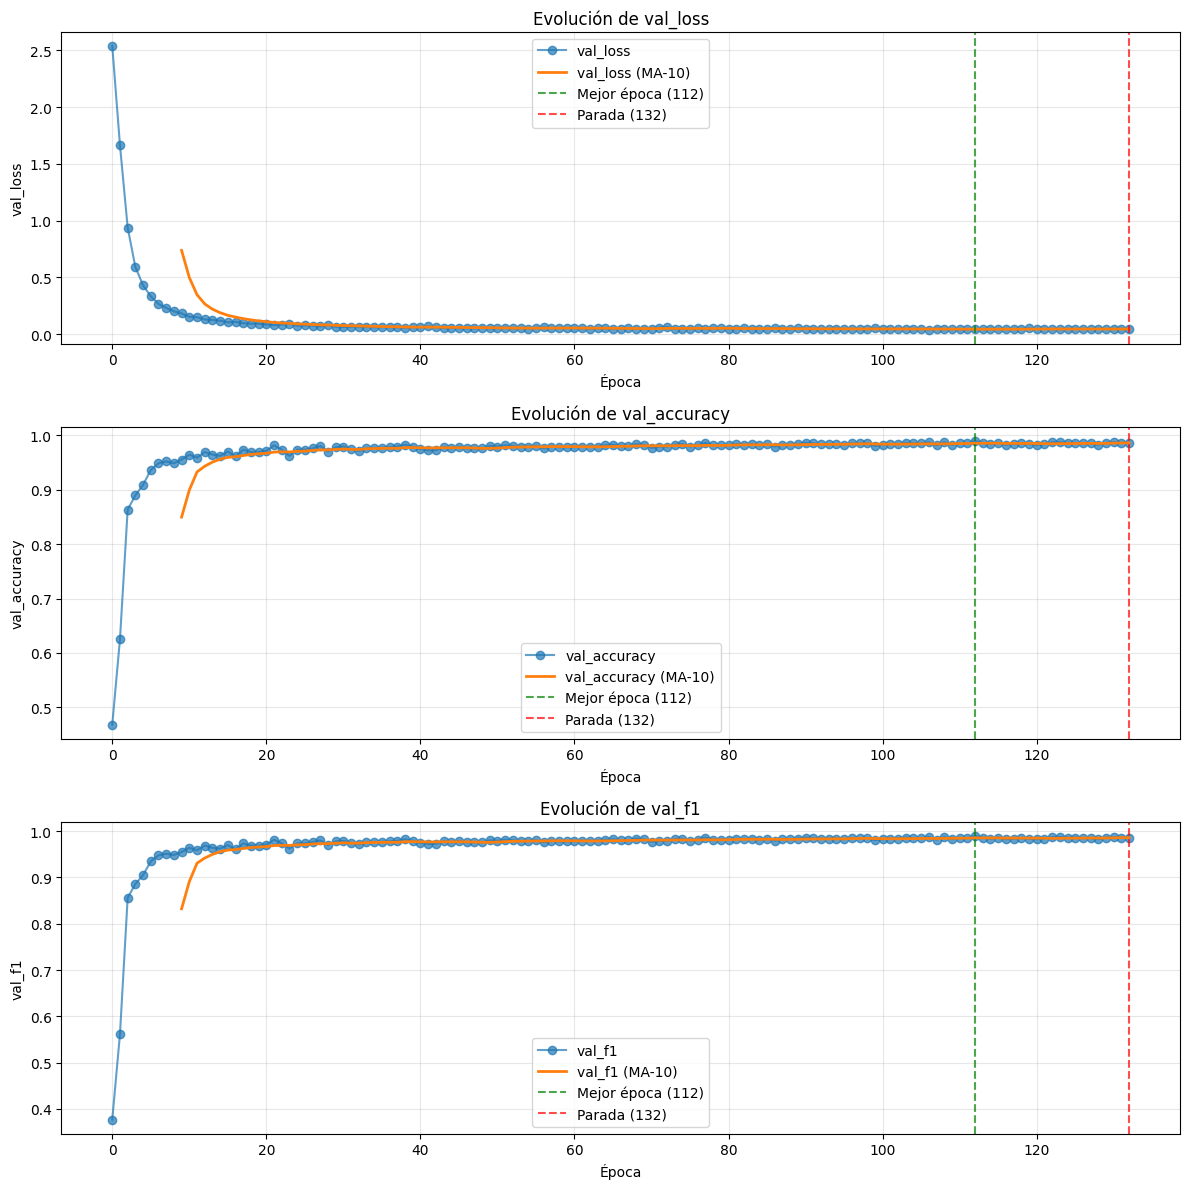

✅ DropClassifier completado en 3.0s

🔄 Entrenando modelo: DeepDropoutClassifier
────────────────────────────────────────

Entrenando modelo: DeepDropoutClassifier
🚀 Iniciando entrenamiento con Early Stopping avanzado
📊 Monitoreando: ['val_loss', 'val_accuracy', 'val_f1']
⏳ Patience inicial: 20
🎯 Min delta: 1e-05
📏 Window size: 10
Época   1/300 | Train Loss: 2.671301 | Val Loss: 2.026203 | Val Acc: 0.6989 | Val F1: 0.6589
✅ Mejora en val_loss: inf → 2.026203
✅ Mejora en val_accuracy: -inf → 0.698864
✅ Mejora en val_f1: -inf → 0.658913
💾 Modelo guardado en checkpoints_DeepDropoutClassifier/best_DeepDropoutClassifier_epoch_0.pth

📊 Estado Early Stopping (Época 0):
   ⏳ Épocas sin mejora: 0/20
   🏆 Mejor época: 0
   📈 val_loss: 2.026203
   📈 val_accuracy: 0.698864
   📈 val_f1: 0.658913
✅ Mejora en val_loss: 2.026203 → 1.470876
✅ Mejora en val_accuracy: 0.698864 → 0.784091
✅ Mejora en val_f1: 0.658913 → 0.761084
💾 Modelo guardado en checkpoints_DeepDropoutClassifier/best_DeepDropoutClassifi

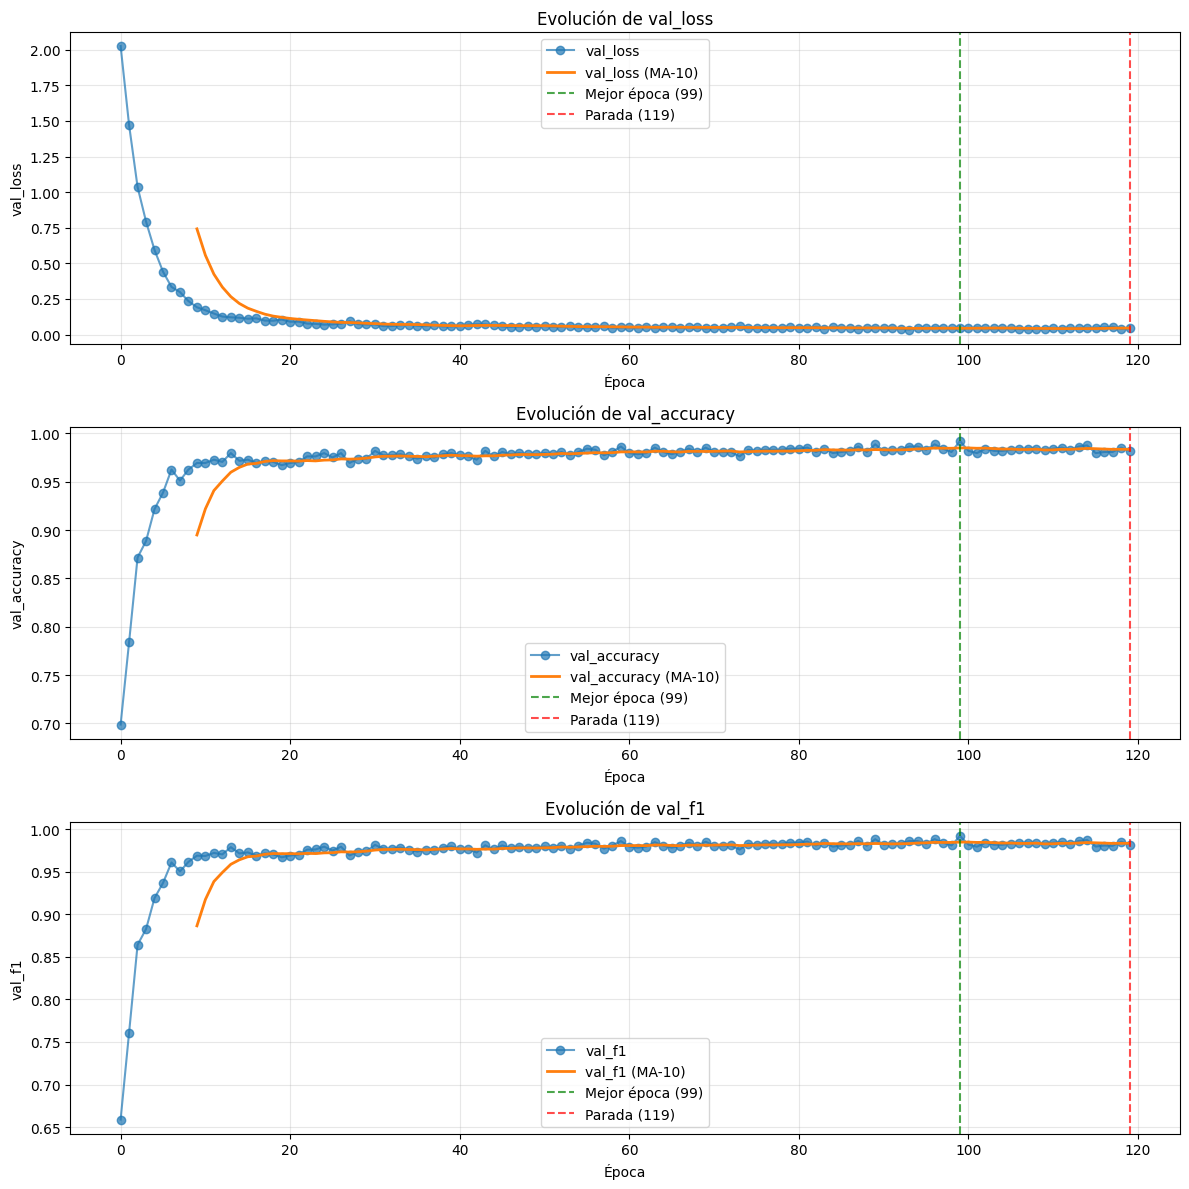

✅ DeepDropoutClassifier completado en 6.9s

🔄 Entrenando modelo: Conv1DClassifier
────────────────────────────────────────

Entrenando modelo: Conv1DClassifier
🚀 Iniciando entrenamiento con Early Stopping avanzado
📊 Monitoreando: ['val_loss', 'val_accuracy', 'val_f1']
⏳ Patience inicial: 20
🎯 Min delta: 1e-05
📏 Window size: 10
Época   1/300 | Train Loss: 2.921264 | Val Loss: 2.632428 | Val Acc: 0.2011 | Val F1: 0.1097
✅ Mejora en val_loss: inf → 2.632428
✅ Mejora en val_accuracy: -inf → 0.201136
✅ Mejora en val_f1: -inf → 0.109673
💾 Modelo guardado en checkpoints_Conv1DClassifier/best_Conv1DClassifier_epoch_0.pth

📊 Estado Early Stopping (Época 0):
   ⏳ Épocas sin mejora: 0/20
   🏆 Mejor época: 0
   📈 val_loss: 2.632428
   📈 val_accuracy: 0.201136
   📈 val_f1: 0.109673
✅ Mejora en val_loss: 2.632428 → 2.223618
✅ Mejora en val_accuracy: 0.201136 → 0.357955
✅ Mejora en val_f1: 0.109673 → 0.291424
💾 Modelo guardado en checkpoints_Conv1DClassifier/best_Conv1DClassifier_epoch_1.pth
✅ Mejora

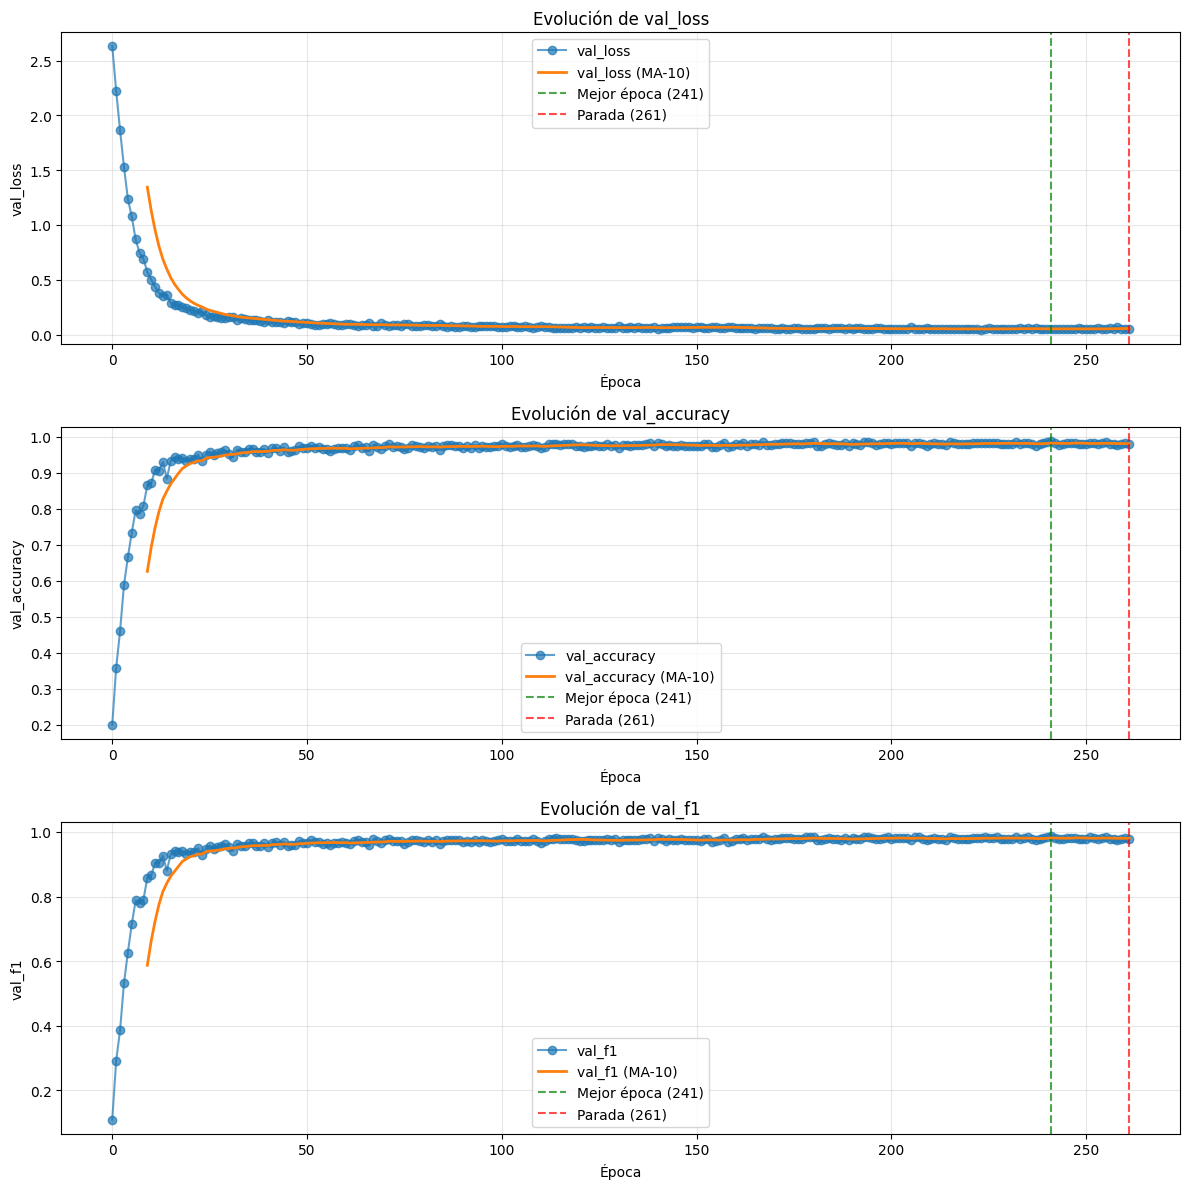

✅ Conv1DClassifier completado en 36.8s
📄 Resultados guardados en model_comparison_results/comparison_results.json


In [336]:
# Entrenar y comparar todos los modelos
comparison_results = comparator.train_and_compare(
    train_loader=train,
    val_loader=val,
    train_function=train_model,
    num_epochs=300,
    lr=0.001
)

In [337]:
# Extraer modelos entrenados para compatibilidad
trained_models = {}
all_train_losses = {}
all_val_losses = {}
training_summaries = {}

for model_name, result in comparator.results.items():
    if 'error' not in result:
        trained_models[model_name] = result['model']
        history = comparator.training_history[model_name]
        all_train_losses[model_name] = history['train_losses']
        all_val_losses[model_name] = history['val_losses']
        training_summaries[model_name] = history['early_stopping_summary']


🎨 GENERANDO VISUALIZACIONES COMPARATIVAS

🎨 Generando visualizaciones comparativas...


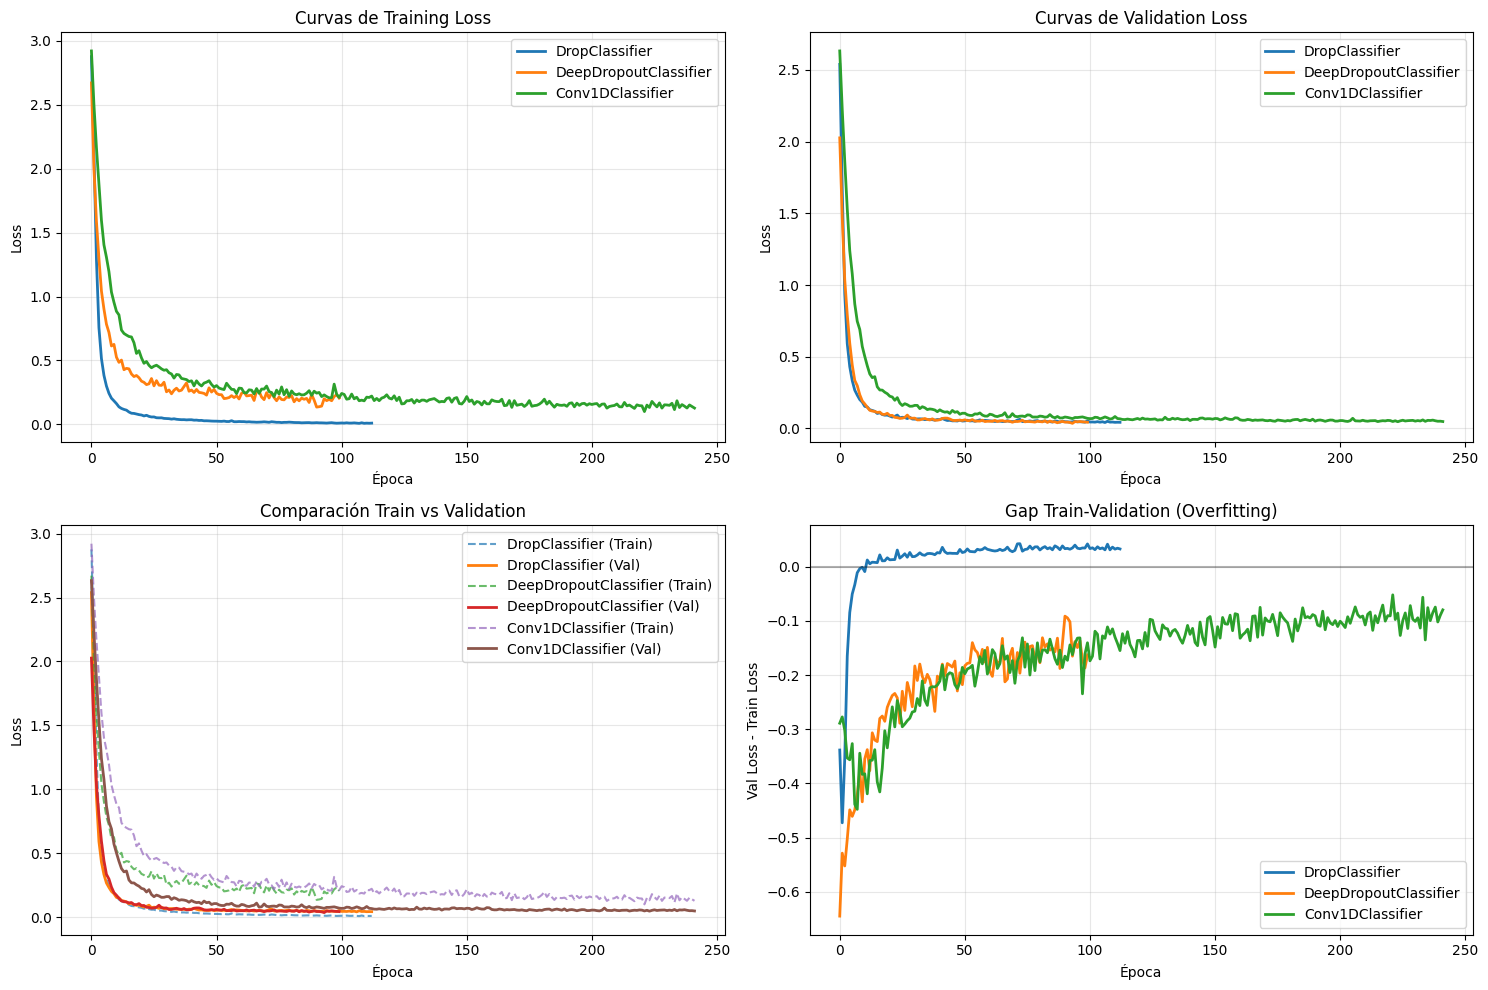

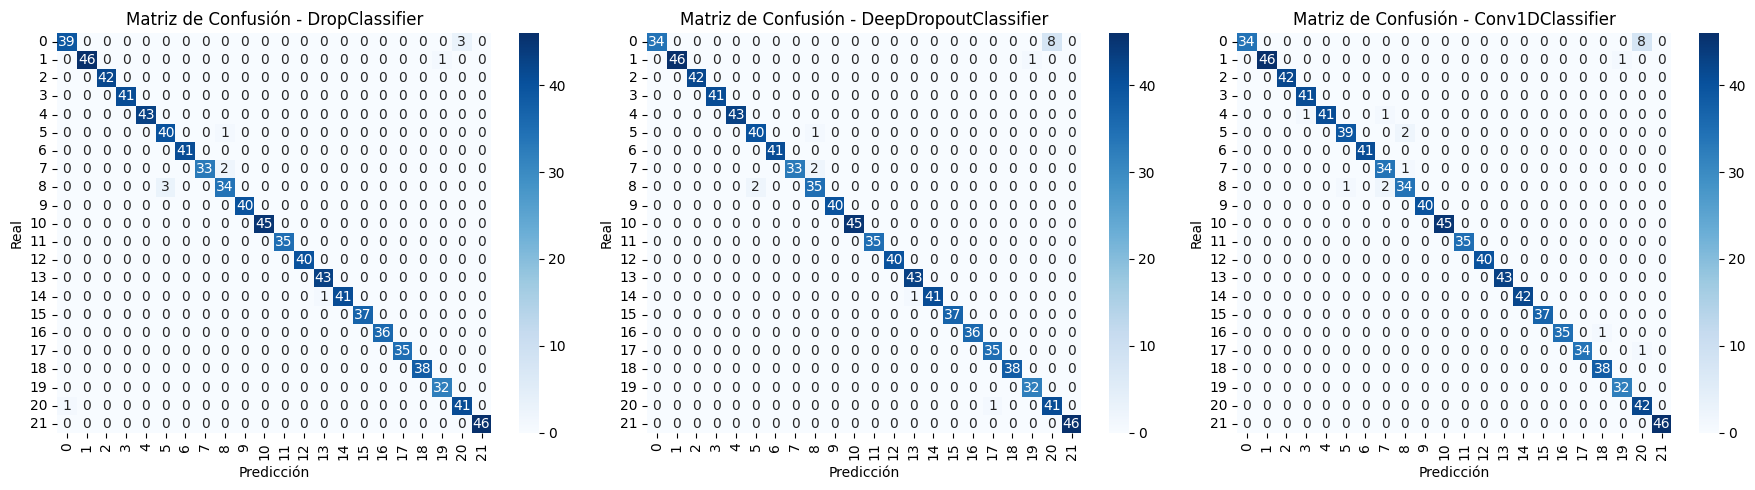

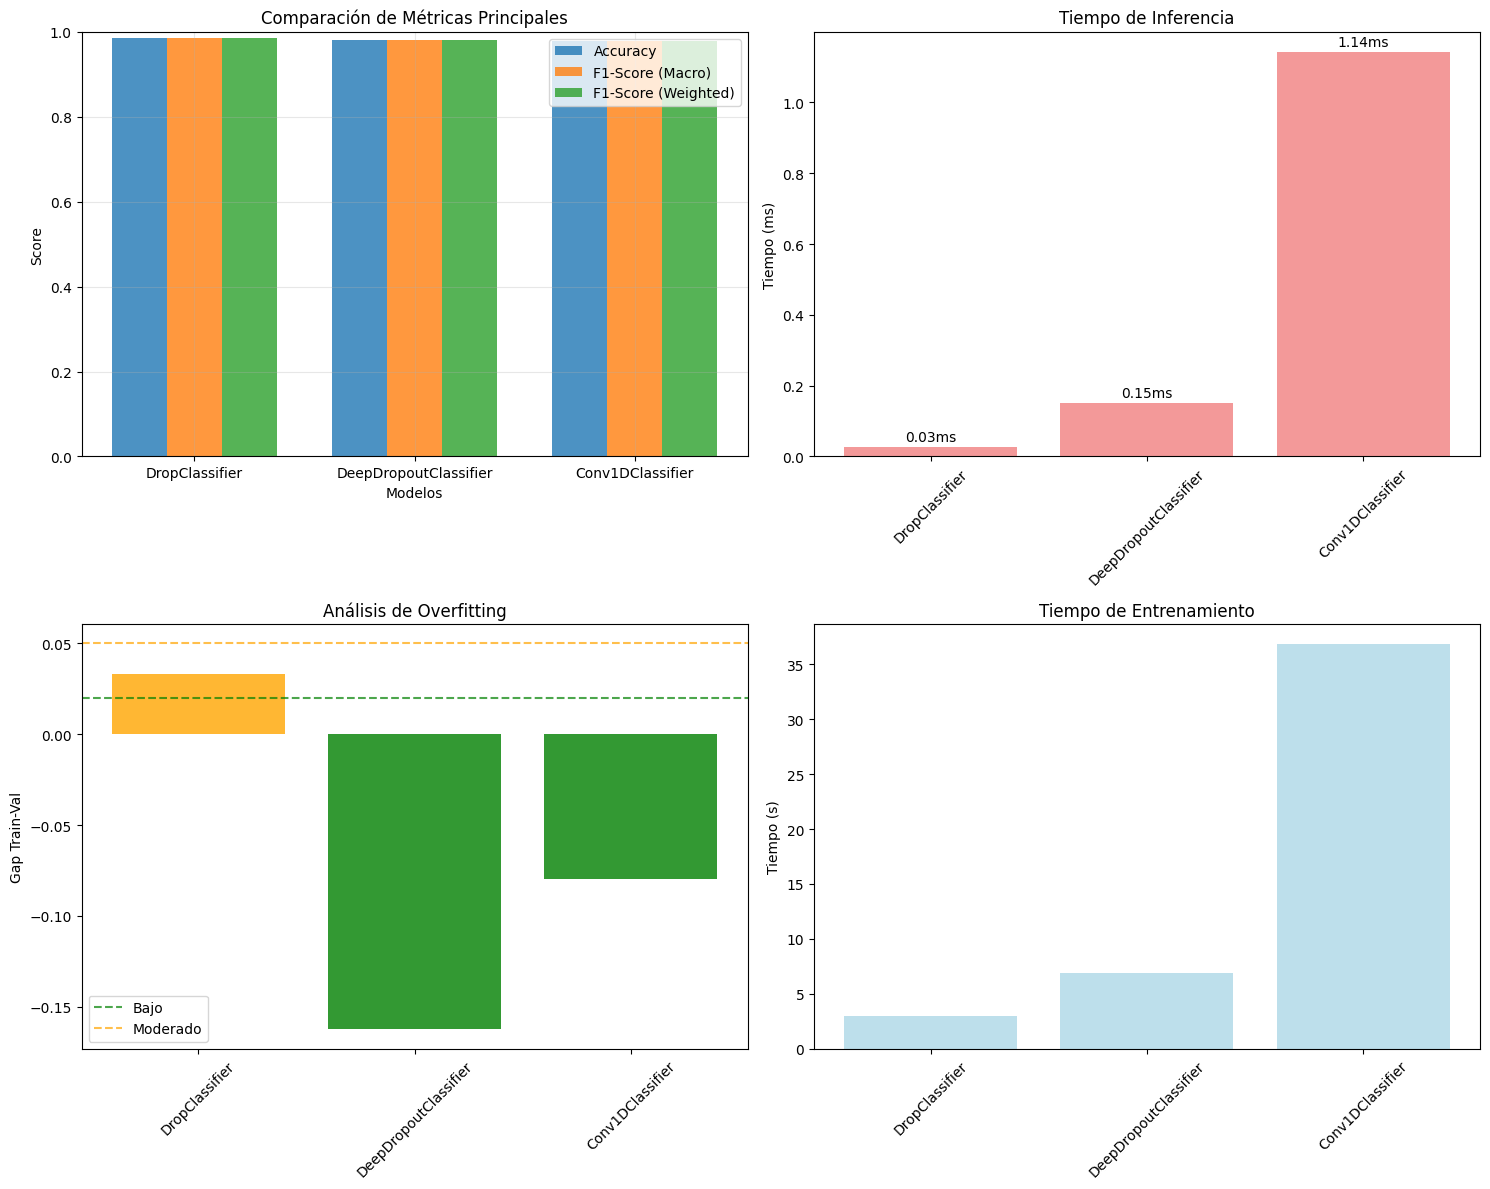

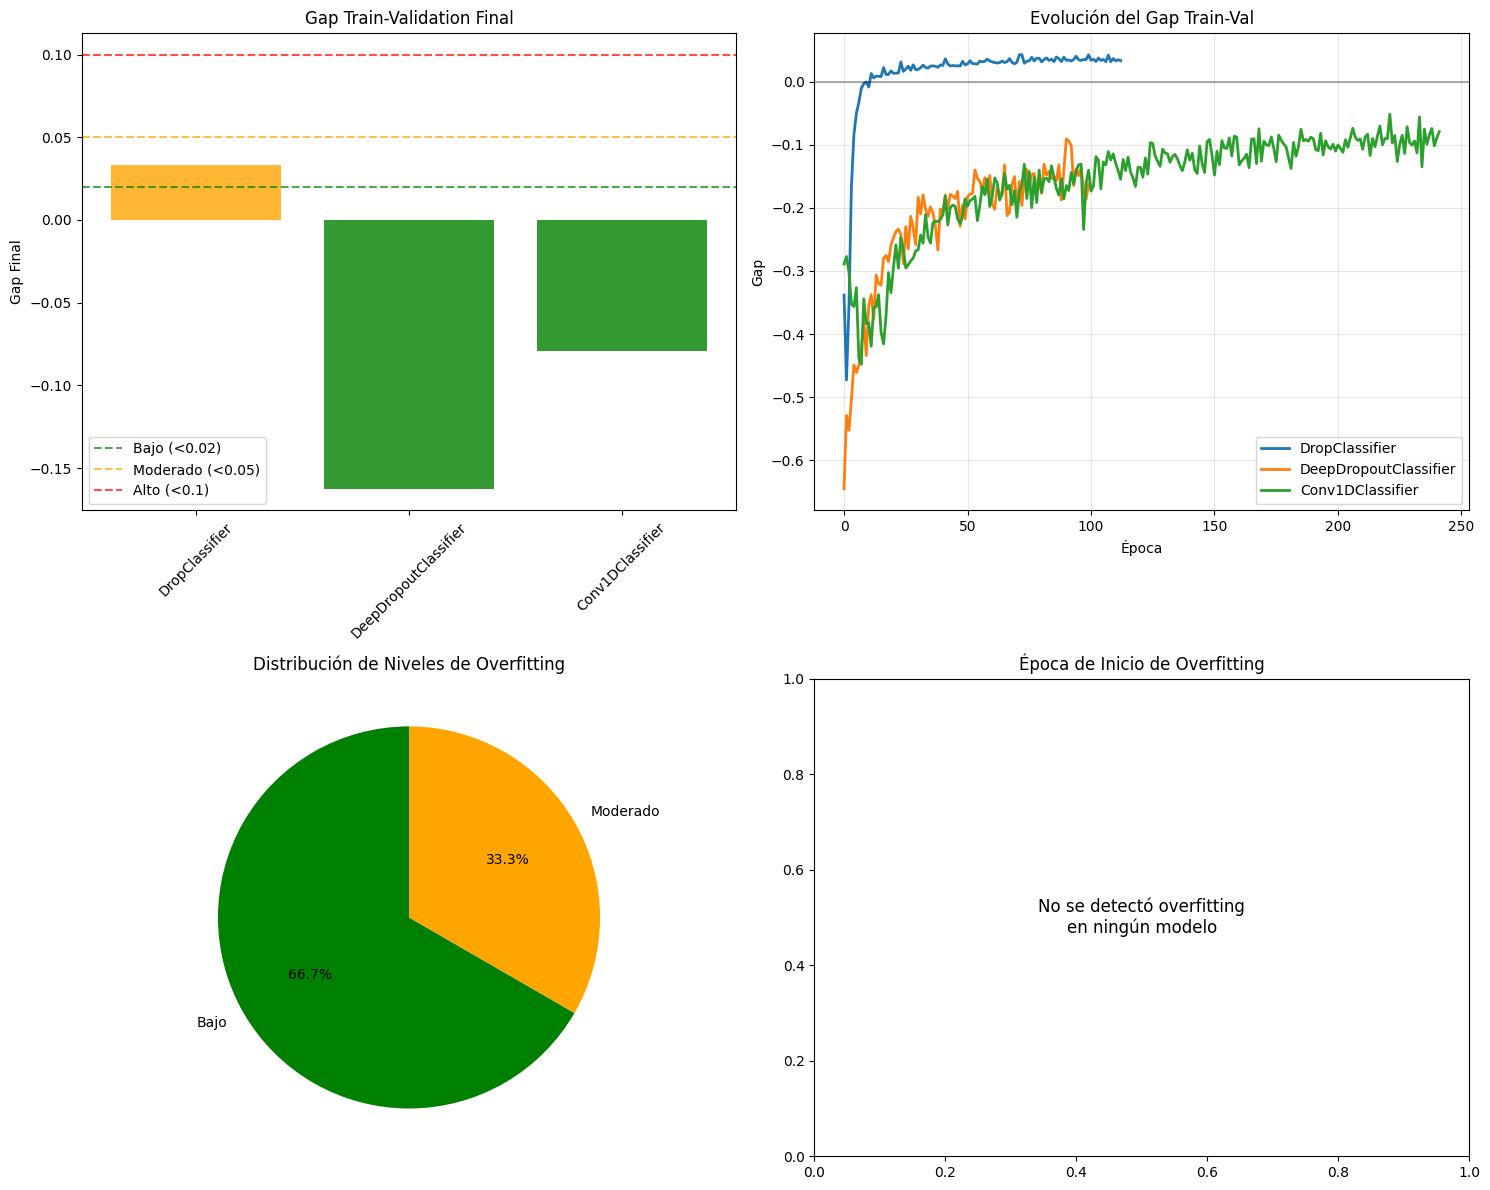

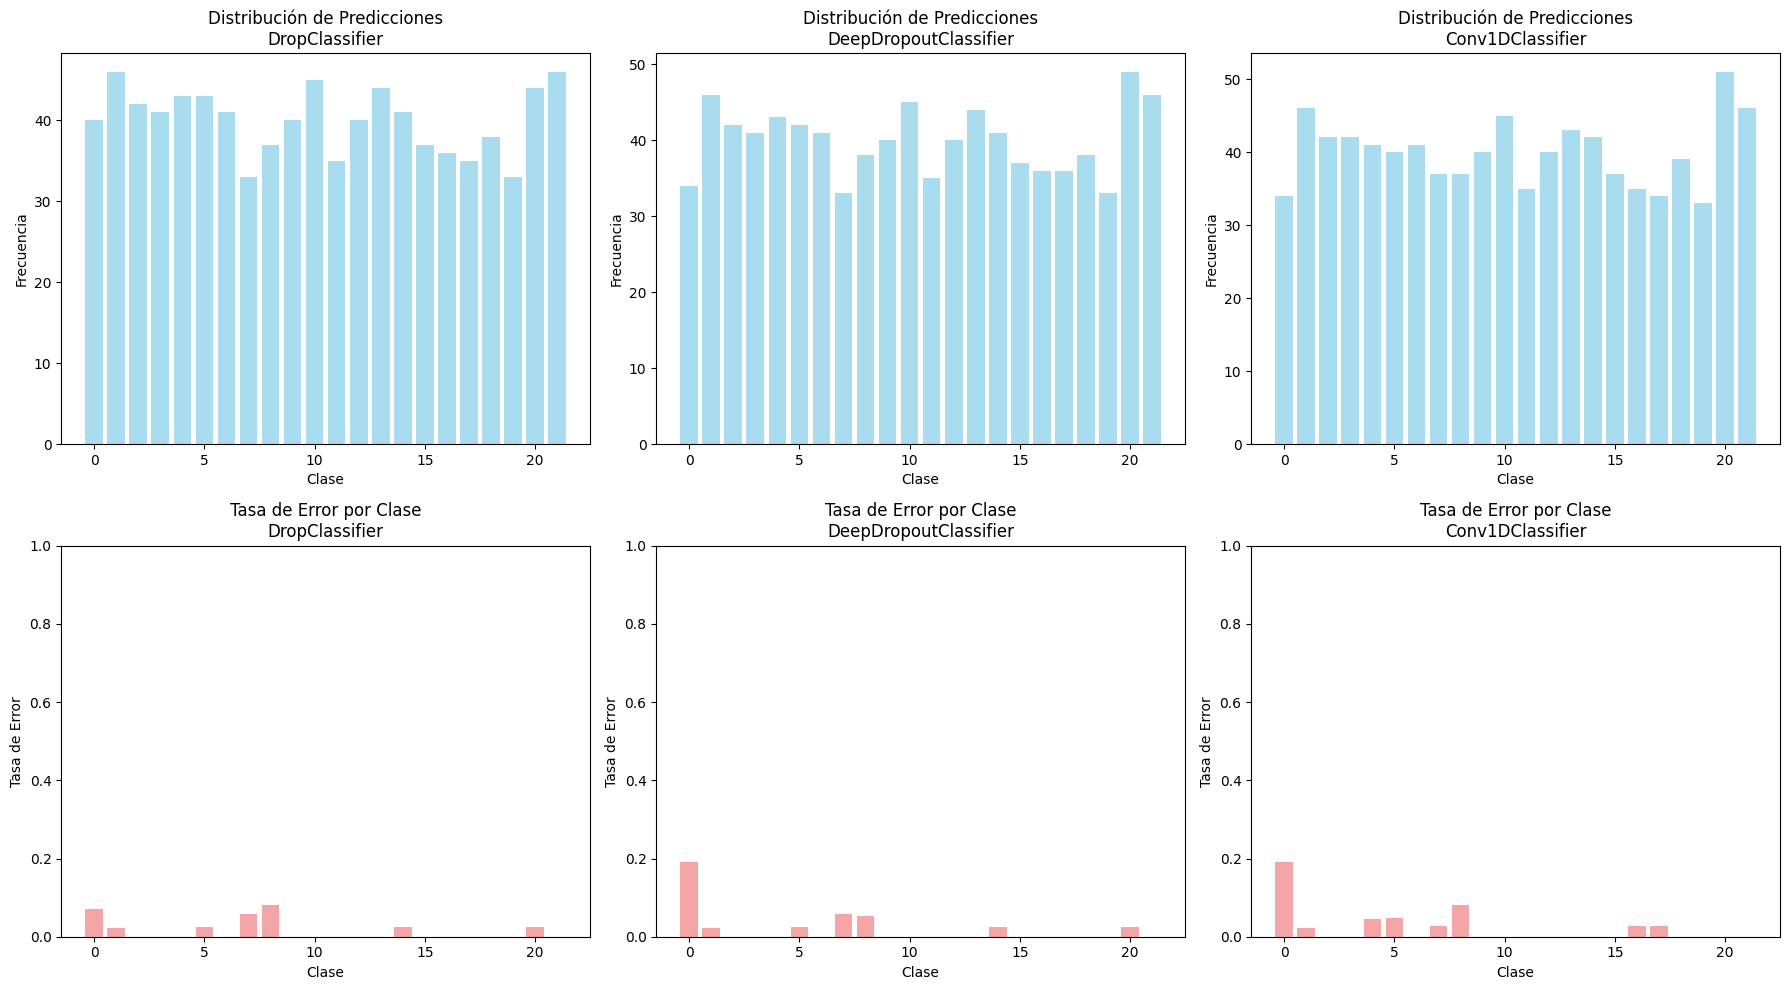

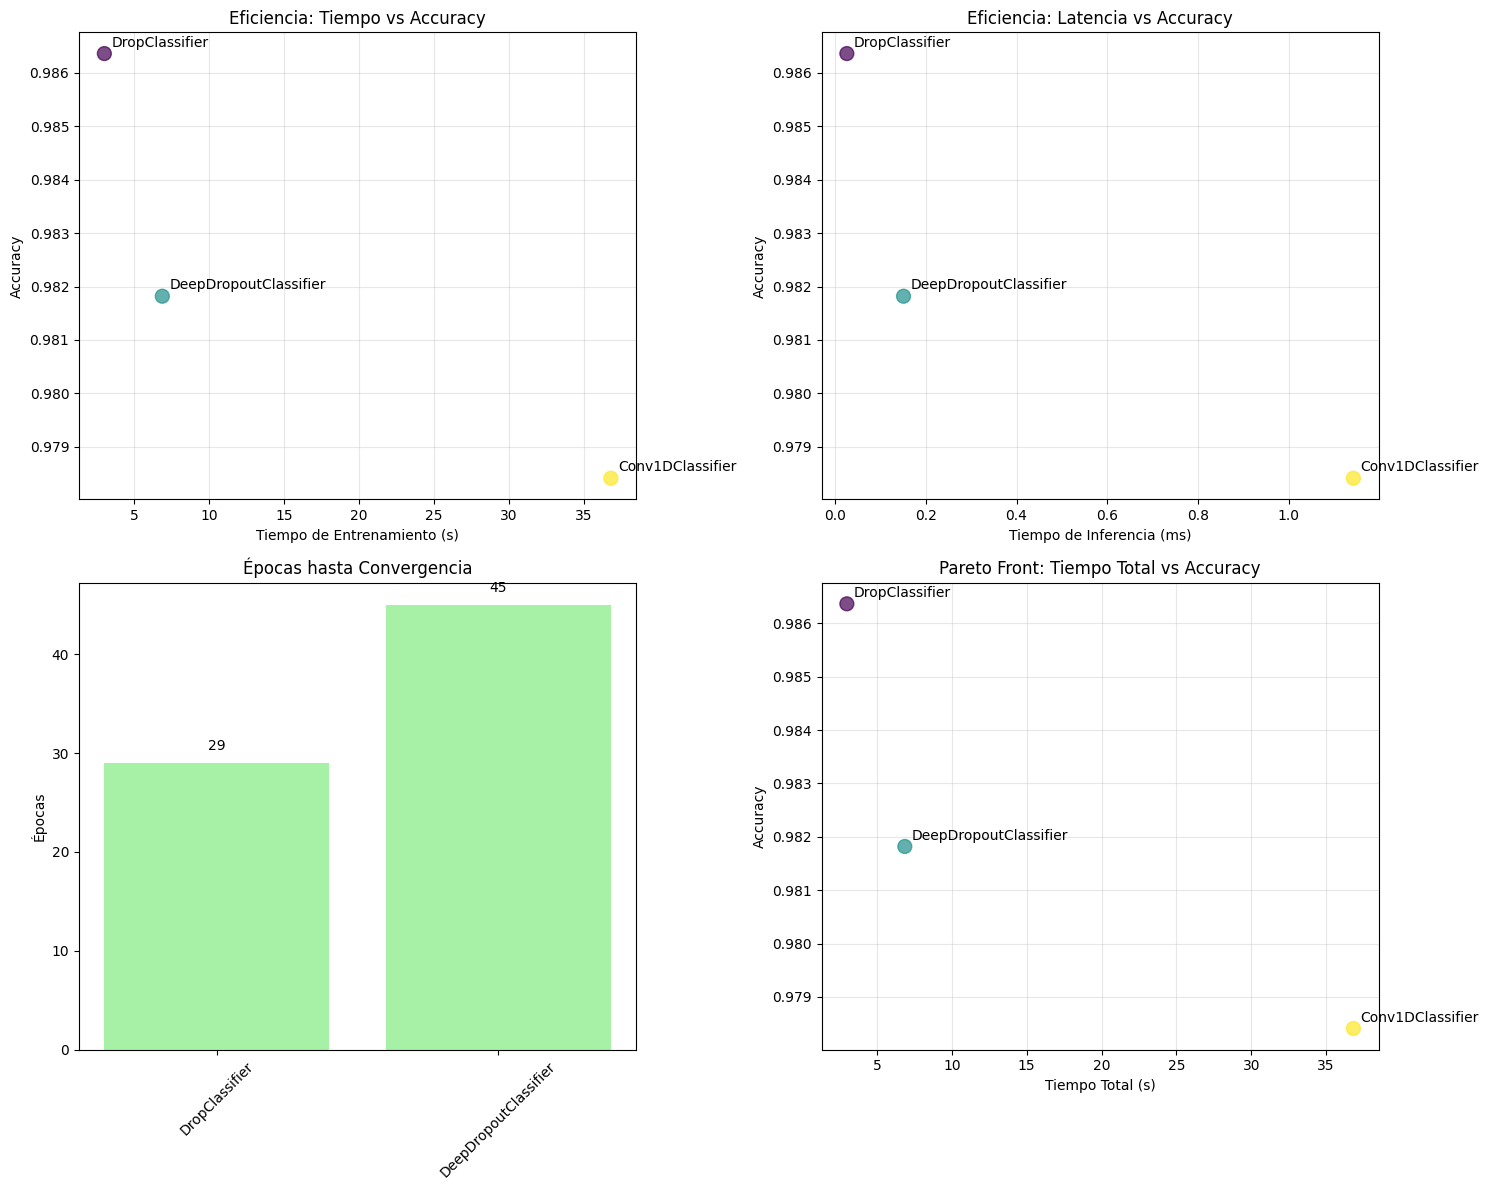

✅ Visualizaciones guardadas en model_comparison_results


In [338]:
# Generar visualizaciones comparativas
print(f"\n🎨 GENERANDO VISUALIZACIONES COMPARATIVAS")
print(f"{'='*60}")
comparator.generate_visualizations()

In [339]:
# Generar reporte de comparación
print(f"\n📄 GENERANDO REPORTE DE COMPARACIÓN")
print(f"{'='*60}")
comparison_report = comparator.generate_report()

# Mostrar tabla comparativa
if 'comparison_table' in comparison_results:
    print(f"\n📊 TABLA COMPARATIVA DE MODELOS")
    print(f"{'='*60}")
    print(comparison_results['comparison_table'].round(4).to_string(index=False))

# Mostrar recomendación
if 'recommendation' in comparison_results:
    recommendation = comparison_results['recommendation']
    print(f"\n🏆 RECOMENDACIÓN FINAL")
    print(f"{'='*60}")
    print(f"🥇 Modelo recomendado: {recommendation['recommended_model']}")
    print(f"📋 Razón: {recommendation['recommendation_reason']}")

    print(f"\n🎯 Mejores modelos por criterio:")
    for criterion, model in recommendation['best_by_criteria'].items():
        print(f"   • {criterion.replace('_', ' ').title()}: {model}")

    print(f"\n💼 Recomendaciones por caso de uso:")
    use_case_descriptions = {
        'production': 'Producción (balance accuracy/velocidad)',
        'research': 'Investigación (máxima accuracy)',
        'real_time': 'Tiempo real (mínima latencia)',
        'limited_resources': 'Recursos limitados (eficiencia)'
    }

    for use_case, model in recommendation['use_cases'].items():
        description = use_case_descriptions.get(use_case, use_case)
        print(f"   • {description}: {model}")

print(f"\n✅ COMPARACIÓN COMPLETADA")
print(f"{'='*60}")
print(f"📁 Resultados guardados en: model_comparison_results/")
print(f"📊 Visualizaciones: loss_curves_comparison.png, metrics_comparison.png, etc.")
print(f"📄 Reporte completo: comparison_report.md")

# Evaluar todos los modelos
results = {}
for model_name, model in trained_models.items():
    print(f"\nEvaluando {model_name}...")
    metrics = evaluate_model(model, val, device, n_classes, label_mapping)
    results[model_name] = metrics

# Mostrar comparación de resultados
print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)

comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Accuracy Global': [results[model]['accuracy_global'] for model in results.keys()],
    'Precision Global': [results[model]['precision_global'] for model in results.keys()],
    'Recall Global': [results[model]['recall_global'] for model in results.keys()],
    'F1-Score Global': [results[model]['f1_score_global'] for model in results.keys()]
})

print(comparison_df.round(4))


📄 GENERANDO REPORTE DE COMPARACIÓN
📄 Reporte guardado en model_comparison_results/comparison_report.md

📊 TABLA COMPARATIVA DE MODELOS
               Modelo  Accuracy  F1-Score (Macro)  F1-Score (Weighted)  Val Loss  Tiempo Entrenamiento (s)  Épocas  Tiempo/Época (s)  Tiempo Inferencia (ms) Overfitting Level  Gap Train-Val  Épocas a Convergencia  Estabilidad Val
       DropClassifier    0.9864            0.9862               0.9864    0.0436                    2.9961     113            0.0265                  0.0260          Moderado         0.0331                   29.0           0.0025
DeepDropoutClassifier    0.9818            0.9818               0.9818    0.0428                    6.8659     100            0.0687                  0.1509              Bajo        -0.1625                   45.0           0.0035
     Conv1DClassifier    0.9784            0.9782               0.9784    0.0533                   36.8151     242            0.1521                  1.1425              Bajo

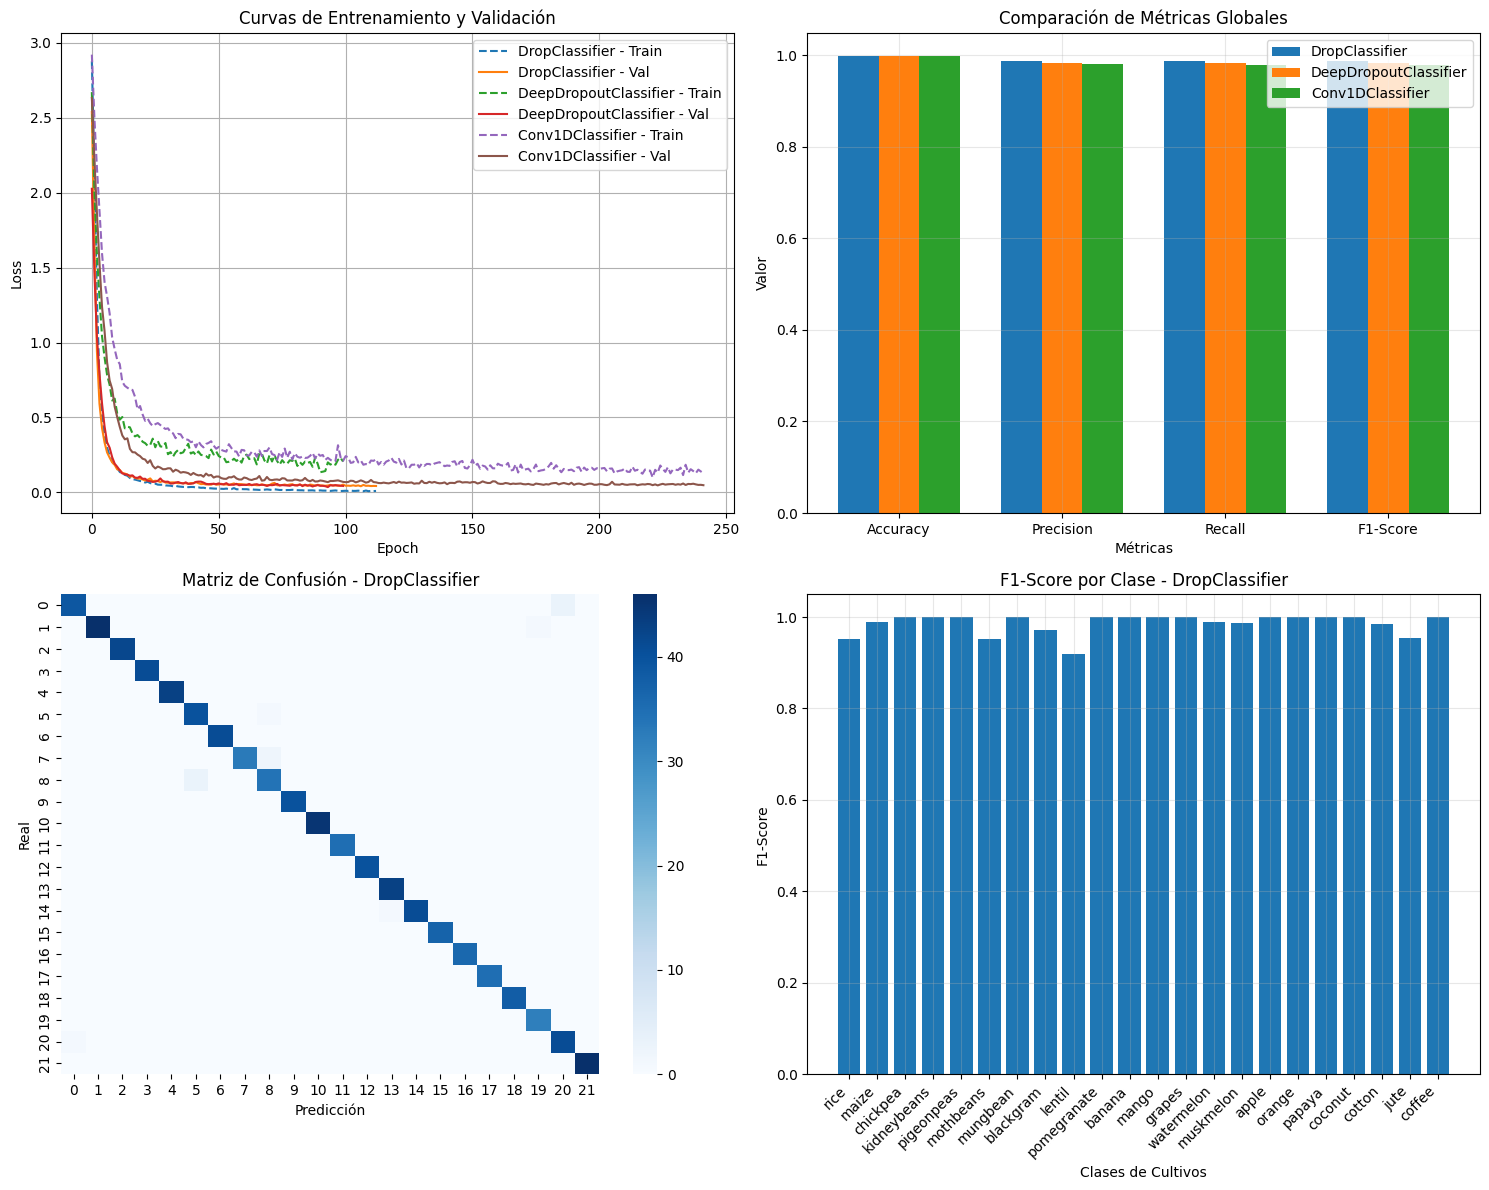

In [340]:
# Gráficas de comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfica 1: Curvas de entrenamiento
ax1 = axes[0, 0]
for model_name in trained_models.keys():
    ax1.plot(all_train_losses[model_name], label=f'{model_name} - Train', linestyle='--')
    ax1.plot(all_val_losses[model_name], label=f'{model_name} - Val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Entrenamiento y Validación')
ax1.legend()
ax1.grid(True)

# Gráfica 2: Comparación de métricas
ax2 = axes[0, 1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_names))
width = 0.25

for i, model_name in enumerate(trained_models.keys()):
    values = [
        results[model_name]['accuracy_global'],
        results[model_name]['precision_global'],
        results[model_name]['recall_global'],
        results[model_name]['f1_score_global']
    ]
    ax2.bar(x + i*width, values, width, label=model_name)

ax2.set_xlabel('Métricas')
ax2.set_ylabel('Valor')
ax2.set_title('Comparación de Métricas Globales')
ax2.set_xticks(x + width)
ax2.set_xticklabels(metrics_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfica 3: Matriz de confusión del mejor modelo
best_model_name = comparison_df.loc[comparison_df['F1-Score Global'].idxmax(), 'Modelo']
ax3 = axes[1, 0]
sns.heatmap(results[best_model_name]['matriz_confusion'], annot=False, cmap='Blues', ax=ax3)
ax3.set_title(f'Matriz de Confusión - {best_model_name}')
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Real')

# Gráfica 4: Distribución de F1-Score por clase para el mejor modelo
ax4 = axes[1, 1]
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
classes = [inverse_label_mapping[i] for i in range(n_classes)]
f1_scores = results[best_model_name]['f1_score']

ax4.bar(range(len(f1_scores)), f1_scores)
ax4.set_xlabel('Clases de Cultivos')
ax4.set_ylabel('F1-Score')
ax4.set_title(f'F1-Score por Clase - {best_model_name}')
ax4.set_xticks(range(len(classes)))
ax4.set_xticklabels(classes, rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [341]:
print(f"\nMejor modelo: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1_score_global']:.4f}")

# Ejemplo de predicción
print("\n" + "="*50)
print("EJEMPLO DE PREDICCIÓN")
print("="*50)

# Ejemplo de datos de entrada (N, P, K, temperature, humidity, ph, rainfall)
ejemplo_features = [90, 42, 43, 20.87, 82.00, 6.50, 202.93]  # Ejemplo para arroz
print(f"Características de entrada: {ejemplo_features}")
print("(N, P, K, temperature, humidity, ph, rainfall)")

# Normalizar las características usando el mismo scaler del dataset
scaler = StandardScaler()

# Necesitamos ajustar el scaler con los datos originales
df_original = pd.read_csv('Crop_recommendation.csv')
feature_columns = df_original.columns[:-1]
scaler.fit(df_original[feature_columns])
ejemplo_normalizado = scaler.transform([ejemplo_features])
ejemplo_tensor = torch.tensor(ejemplo_normalizado, dtype=torch.float32)

print(f"\nPredicciones de cada modelo:")
for model_name, model in trained_models.items():
    predicted_crop, probabilities = predict_crop_with_device(model, ejemplo_tensor, label_mapping, device)
    confidence = np.max(probabilities)
    print(f"{model_name}: {predicted_crop} (confianza: {confidence:.3f})")

# Mostrar métricas detalladas del mejor modelo
print(f"\n" + "="*50)
print(f"MÉTRICAS DETALLADAS - {best_model_name}")
print("="*50)

best_metrics = results[best_model_name]
detailed_df = pd.DataFrame({
    'Cultivo': classes,
    'Precision': best_metrics['precision'],
    'Recall': best_metrics['recall'],
    'F1 Score': best_metrics['f1_score'],
    'Accuracy': best_metrics['accuracy_por_clase']
})

print(detailed_df.round(4))

# Análisis adicional usando las utilidades
print("\n" + "="*80)
print("ANÁLISIS ADICIONAL CON UTILIDADES")
print("="*80)


Mejor modelo: DropClassifier
F1-Score: 0.9864

EJEMPLO DE PREDICCIÓN
Características de entrada: [90, 42, 43, 20.87, 82.0, 6.5, 202.93]
(N, P, K, temperature, humidity, ph, rainfall)

Predicciones de cada modelo:
DropClassifier: rice (confianza: 0.987)
DeepDropoutClassifier: rice (confianza: 0.520)
Conv1DClassifier: rice (confianza: 0.839)

MÉTRICAS DETALLADAS - DropClassifier
        Cultivo  Precision  Recall  F1 Score  Accuracy
0          rice     0.9750  0.9286    0.9512    0.9955
1         maize     1.0000  0.9787    0.9892    0.9989
2      chickpea     1.0000  1.0000    1.0000    1.0000
3   kidneybeans     1.0000  1.0000    1.0000    1.0000
4    pigeonpeas     1.0000  1.0000    1.0000    1.0000
5     mothbeans     0.9302  0.9756    0.9524    0.9955
6      mungbean     1.0000  1.0000    1.0000    1.0000
7     blackgram     1.0000  0.9429    0.9706    0.9977
8        lentil     0.9189  0.9189    0.9189    0.9932
9   pomegranate     1.0000  1.0000    1.0000    1.0000
10       banan

/Users/luisrico/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Utilidades para análisis y comparación de modelos de recomendación de cultivos

In [342]:
def count_parameters(model):
    """Cuenta el número de parámetros entrenables en un modelo"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [343]:
def model_summary(models_dict):
    """
    Genera un resumen de los modelos incluyendo número de parámetros
    """
    summary_data = []

    for name, model in models_dict.items():
        param_count = count_parameters(model)

        # Calcular tamaño aproximado en MB
        param_size_mb = param_count * 4 / (1024 * 1024)  # 4 bytes por parámetro float32

        summary_data.append({
            'Modelo': name,
            'Parámetros': param_count,
            'Tamaño (MB)': round(param_size_mb, 2)
        })

    return pd.DataFrame(summary_data)

In [344]:
def benchmark_inference_time(models_dict, sample_input, device, num_runs=100):
    """
    Mide el tiempo de inferencia de cada modelo
    """
    timing_results = {}

    for name, model in models_dict.items():
        model.eval()
        model.to(device)
        sample_input = sample_input.to(device)

        # Warm-up
        with torch.no_grad():
            for _ in range(10):
                _ = model(sample_input)

        # Medición real
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        start_time = time.time()

        with torch.no_grad():
            for _ in range(num_runs):
                _ = model(sample_input)

        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end_time = time.time()

        avg_time = (end_time - start_time) / num_runs * 1000  # en milisegundos
        timing_results[name] = avg_time

    return timing_results

In [345]:
def plot_model_comparison(results, timing_results=None, param_counts=None):
    """
    Crea gráficas comparativas detalladas de los modelos
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    model_names = list(results.keys())

    # 1. Métricas principales
    ax1 = axes[0, 0]
    metrics = ['accuracy_global', 'precision_global', 'recall_global', 'f1_score_global']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    x = np.arange(len(metric_labels))
    width = 0.25

    for i, model_name in enumerate(model_names):
        values = [results[model_name][metric] for metric in metrics]
        ax1.bar(x + i*width, values, width, label=model_name, alpha=0.8)

    ax1.set_xlabel('Métricas')
    ax1.set_ylabel('Valor')
    ax1.set_title('Comparación de Métricas Globales')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(metric_labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    # 2. Tiempo de inferencia (si está disponible)
    if timing_results:
        ax2 = axes[0, 1]
        times = [timing_results[name] for name in model_names]
        bars = ax2.bar(model_names, times, color=['skyblue', 'lightgreen', 'lightcoral'])
        ax2.set_ylabel('Tiempo (ms)')
        ax2.set_title('Tiempo de Inferencia Promedio')
        ax2.tick_params(axis='x', rotation=45)

        # Agregar valores en las barras
        for bar, time_val in zip(bars, times):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{time_val:.2f}ms', ha='center', va='bottom')
    else:
        axes[0, 1].axis('off')

    # 3. Número de parámetros (si está disponible)
    if param_counts:
        ax3 = axes[0, 2]
        params = [param_counts[name] for name in model_names]
        bars = ax3.bar(model_names, params, color=['gold', 'orange', 'red'])
        ax3.set_ylabel('Número de Parámetros')
        ax3.set_title('Complejidad del Modelo')
        ax3.tick_params(axis='x', rotation=45)

        # Agregar valores en las barras
        for bar, param_val in zip(bars, params):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(params)*0.01,
                    f'{param_val:,}', ha='center', va='bottom')
    else:
        axes[0, 2].axis('off')

    # 4. Distribución de F1-Score por clase
    ax4 = axes[1, 0]
    best_model = max(results.keys(), key=lambda x: results[x]['f1_score_global'])
    f1_scores = results[best_model]['f1_score']

    ax4.hist(f1_scores, bins=20, alpha=0.7, color='purple', edgecolor='black')
    ax4.set_xlabel('F1-Score')
    ax4.set_ylabel('Número de Clases')
    ax4.set_title(f'Distribución F1-Score por Clase\n({best_model})')
    ax4.grid(True, alpha=0.3)

    # 5. Comparación de varianza en métricas
    ax5 = axes[1, 1]
    f1_variances = [np.var(results[name]['f1_score']) for name in model_names]
    bars = ax5.bar(model_names, f1_variances, color=['lightblue', 'lightgreen', 'lightpink'])
    ax5.set_ylabel('Varianza F1-Score')
    ax5.set_title('Consistencia entre Clases')
    ax5.tick_params(axis='x', rotation=45)

    # 6. Radar chart de métricas principales
    ax6 = axes[1, 2]
    angles = np.linspace(0, 2*np.pi, len(metric_labels), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo

    for model_name in model_names:
        values = [results[model_name][metric] for metric in metrics]
        values += values[:1]  # Cerrar el círculo
        ax6.plot(angles, values, 'o-', linewidth=2, label=model_name)
        ax6.fill(angles, values, alpha=0.25)

    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(metric_labels)
    ax6.set_ylim(0, 1)
    ax6.set_title('Radar Chart - Métricas')
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

In [346]:
def analyze_class_performance(results, label_mapping, top_n=5):
    """
    Analiza el rendimiento por clase y encuentra las mejores y peores clases
    """
    inverse_mapping = {v: k for k, v in label_mapping.items()}

    analysis_results = {}

    for model_name, metrics in results.items():
        f1_scores = metrics['f1_score']

        # Crear DataFrame con cultivos y F1-scores
        class_performance = pd.DataFrame({
            'Cultivo': [inverse_mapping[i] for i in range(len(f1_scores))],
            'F1_Score': f1_scores,
            'Precision': metrics['precision'],
            'Recall': metrics['recall']
        })

        # Ordenar por F1-Score
        class_performance = class_performance.sort_values('F1_Score', ascending=False)

        analysis_results[model_name] = {
            'best_classes': class_performance.head(top_n),
            'worst_classes': class_performance.tail(top_n),
            'mean_f1': class_performance['F1_Score'].mean(),
            'std_f1': class_performance['F1_Score'].std()
        }

    return analysis_results

In [347]:
def generate_model_report(results, models_dict, label_mapping, timing_results=None):
    """
    Genera un reporte completo de comparación de modelos
    """
    print("="*80)
    print("REPORTE COMPLETO DE COMPARACIÓN DE MODELOS")
    print("="*80)

    # 1. Resumen de arquitecturas
    print("\n1. RESUMEN DE ARQUITECTURAS")
    print("-" * 40)
    model_summary_df = model_summary(models_dict)
    print(model_summary_df.to_string(index=False))

    # 2. Métricas de rendimiento
    print("\n2. MÉTRICAS DE RENDIMIENTO")
    print("-" * 40)
    performance_df = pd.DataFrame({
        'Modelo': list(results.keys()),
        'Accuracy': [results[model]['accuracy_global'] for model in results.keys()],
        'Precision': [results[model]['precision_global'] for model in results.keys()],
        'Recall': [results[model]['recall_global'] for model in results.keys()],
        'F1-Score': [results[model]['f1_score_global'] for model in results.keys()]
    })
    print(performance_df.round(4).to_string(index=False))

    # 3. Tiempo de inferencia
    if timing_results:
        print("\n3. TIEMPO DE INFERENCIA")
        print("-" * 40)
        timing_df = pd.DataFrame({
            'Modelo': list(timing_results.keys()),
            'Tiempo Promedio (ms)': list(timing_results.values())
        })
        print(timing_df.round(3).to_string(index=False))

    # 4. Análisis por clase
    print("\n4. ANÁLISIS POR CLASE (TOP 3 MEJORES Y PEORES)")
    print("-" * 40)
    class_analysis = analyze_class_performance(results, label_mapping, top_n=3)

    for model_name, analysis in class_analysis.items():
        print(f"\n{model_name}:")
        print(f"  F1-Score promedio: {analysis['mean_f1']:.4f} ± {analysis['std_f1']:.4f}")
        print("  Mejores clases:")
        for _, row in analysis['best_classes'].iterrows():
            print(f"    {row['Cultivo']}: {row['F1_Score']:.4f}")
        print("  Peores clases:")
        for _, row in analysis['worst_classes'].iterrows():
            print(f"    {row['Cultivo']}: {row['F1_Score']:.4f}")

    # 5. Recomendación final
    print("\n5. RECOMENDACIÓN FINAL")
    print("-" * 40)
    best_model = max(results.keys(), key=lambda x: results[x]['f1_score_global'])
    best_f1 = results[best_model]['f1_score_global']

    print(f"Modelo recomendado: {best_model}")
    print(f"F1-Score: {best_f1:.4f}")

    # Justificación
    param_count = count_parameters(models_dict[best_model])
    print(f"Parámetros: {param_count:,}")

    if timing_results and best_model in timing_results:
        print(f"Tiempo de inferencia: {timing_results[best_model]:.2f} ms")

    print("\nJustificación:")
    if best_f1 > 0.95:
        print("- Excelente rendimiento en todas las métricas")
    elif best_f1 > 0.90:
        print("- Muy buen rendimiento general")
    else:
        print("- Rendimiento aceptable, considerar mejoras")

    return best_model

In [348]:
def save_models(trained_models, save_dir="saved_models"):
    """
    Guarda todos los modelos entrenados
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for model_name, model in trained_models.items():
        save_path = os.path.join(save_dir, f"{model_name}.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_class': model.__class__.__name__
        }, save_path)
        print(f"Modelo {model_name} guardado en {save_path}")

In [349]:
def load_model(model_class, model_path, n_classes, device):
    """
    Carga un modelo guardado
    """
    checkpoint = torch.load(model_path, map_location=device)
    model = model_class(n_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

In [350]:
# 1. Resumen de modelos
print("\nRESUMEN DE ARQUITECTURAS:")
summary_df = model_summary(models)
print(summary_df.to_string(index=False))


RESUMEN DE ARQUITECTURAS:
               Modelo  Parámetros  Tamaño (MB)
       DropClassifier        6102         0.02
DeepDropoutClassifier       77782         0.30
     Conv1DClassifier       86380         0.33


In [351]:
# 2. Benchmark de tiempo de inferencia
print("\nMidiendo tiempos de inferencia...")
sample_input = torch.randn(32, 7)  # Batch de 32 muestras
timing_results = benchmark_inference_time(trained_models, sample_input, device, num_runs=50)

print("\nTiempos de inferencia:")
for model_name, time_ms in timing_results.items():
    print(f"{model_name}: {time_ms:.3f} ms")


Midiendo tiempos de inferencia...

Tiempos de inferencia:
DropClassifier: 0.034 ms
DeepDropoutClassifier: 0.118 ms
Conv1DClassifier: 0.757 ms


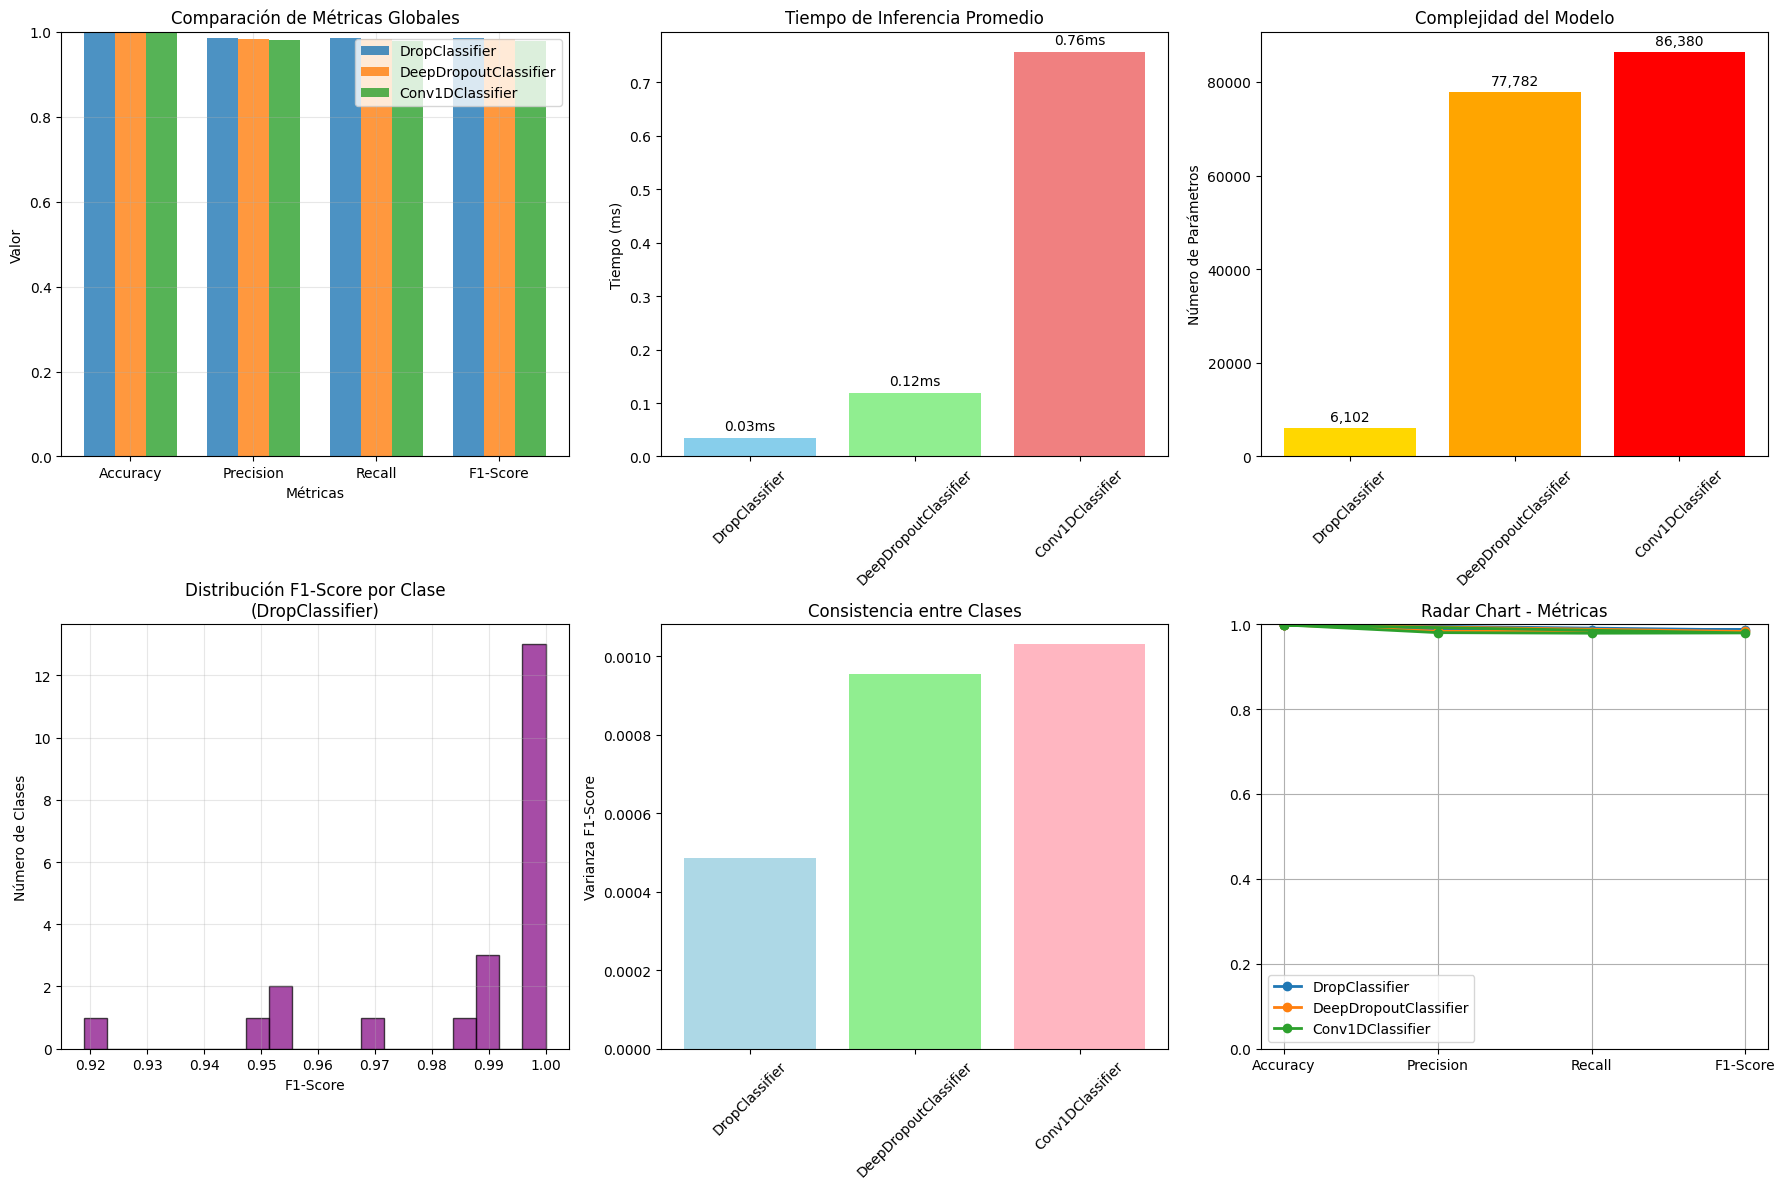

In [352]:
# 3. Gráficas comparativas detalladas
param_counts = {name: count_parameters(model) for name, model in models.items()}
plot_model_comparison(results, timing_results, param_counts)

In [353]:
# 4. Reporte completo
recommended_model = generate_model_report(results, models, label_mapping, timing_results)

REPORTE COMPLETO DE COMPARACIÓN DE MODELOS

1. RESUMEN DE ARQUITECTURAS
----------------------------------------
               Modelo  Parámetros  Tamaño (MB)
       DropClassifier        6102         0.02
DeepDropoutClassifier       77782         0.30
     Conv1DClassifier       86380         0.33

2. MÉTRICAS DE RENDIMIENTO
----------------------------------------
               Modelo  Accuracy  Precision  Recall  F1-Score
       DropClassifier    0.9988     0.9865  0.9862    0.9864
DeepDropoutClassifier    0.9983     0.9832  0.9820    0.9826
     Conv1DClassifier    0.9980     0.9798  0.9785    0.9792

3. TIEMPO DE INFERENCIA
----------------------------------------
               Modelo  Tiempo Promedio (ms)
       DropClassifier                 0.034
DeepDropoutClassifier                 0.118
     Conv1DClassifier                 0.757

4. ANÁLISIS POR CLASE (TOP 3 MEJORES Y PEORES)
----------------------------------------

DropClassifier:
  F1-Score promedio: 0.9862 ± 0.0226
 

In [354]:
class CropRecommendationEngine:
    """
    Motor de inferencia para recomendación de cultivos.

    Características:
    - Carga automática de modelos entrenados
    - Normalización automática de características
    - Predicciones con probabilidades y confianza
    - Soporte para múltiples modelos
    - Manejo robusto de errores
    - Interfaz simple para uso en producción
    """

    def __init__(self, model_dir: str = "saved_models",
                 scaler_path: str = "scaler.pkl",
                 label_mapping_path: str = "label_mapping.json",
                 default_model: str = "best_model"):
        """
        Inicializa el motor de inferencia.

        Args:
            model_dir (str): Directorio con modelos guardados
            scaler_path (str): Ruta al scaler entrenado
            label_mapping_path (str): Ruta al mapeo de etiquetas
            default_model (str): Modelo por defecto a usar
        """
        self.model_dir = model_dir
        self.scaler_path = scaler_path
        self.label_mapping_path = label_mapping_path
        self.default_model = default_model

        # Componentes del sistema
        self.models = {}
        self.scaler = None
        self.label_mapping = {}
        self.inverse_label_mapping = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Metadatos
        self.feature_names = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
        self.feature_descriptions = {
            "N": "Contenido de nitrógeno en el suelo (kg/ha)",
            "P": "Contenido de fósforo en el suelo (kg/ha)",
            "K": "Contenido de potasio en el suelo (kg/ha)",
            "temperature": "Temperatura promedio (°C)",
            "humidity": "Humedad relativa (%)",
            "ph": "Nivel de pH del suelo",
            "rainfall": "Precipitación anual (mm)"
        }

        # Rangos típicos para validación
        self.feature_ranges = {
            "N": (0, 200),
            "P": (0, 150),
            "K": (0, 250),
            "temperature": (8, 45),
            "humidity": (10, 100),
            "ph": (3.5, 10.0),
            "rainfall": (20, 3000)
        }

        print(f"🚀 CropRecommendationEngine inicializado")
        print(f"📁 Directorio de modelos: {model_dir}")
        print(f"💻 Dispositivo: {self.device}")

        # Inicializar componentes
        self._initialize_components()

    def _initialize_components(self):
        """Inicializa todos los componentes del sistema."""
        try:
            # Cargar scaler
            self._load_scaler()

            # Cargar mapeo de etiquetas
            self._load_label_mapping()

            # Cargar modelos disponibles
            self._load_available_models()

            print(f"✅ Sistema inicializado correctamente")
            print(f"📊 Modelos disponibles: {list(self.models.keys())}")
            print(f"🏷️  Cultivos soportados: {len(self.label_mapping)}")

        except Exception as e:
            print(f"❌ Error inicializando sistema: {e}")
            self._create_fallback_components()

    def _load_scaler(self):
        """Carga el scaler entrenado."""
        try:
            if os.path.exists(self.scaler_path):
                with open(self.scaler_path, 'rb') as f:
                    self.scaler = pickle.load(f)
                print(f"✅ Scaler cargado desde {self.scaler_path}")
            else:
                # Crear scaler desde dataset original si existe
                self._create_scaler_from_dataset()
        except Exception as e:
            print(f"⚠️ Error cargando scaler: {e}")
            self._create_fallback_scaler()

    def _create_scaler_from_dataset(self):
        """Crea scaler desde el dataset original."""
        try:
            if os.path.exists('Crop_recommendation.csv'):
                df = pd.read_csv('Crop_recommendation.csv')
                feature_columns = df.columns[:-1]  # Todas excepto 'label'

                self.scaler = StandardScaler()
                self.scaler.fit(df[feature_columns])

                # Guardar scaler
                with open(self.scaler_path, 'wb') as f:
                    pickle.dump(self.scaler, f)

                print(f"✅ Scaler creado desde dataset y guardado en {self.scaler_path}")
            else:
                raise FileNotFoundError("Dataset original no encontrado")
        except Exception as e:
            print(f"⚠️ Error creando scaler desde dataset: {e}")
            self._create_fallback_scaler()

    def _create_fallback_scaler(self):
        """Crea un scaler de respaldo con valores típicos."""
        print("🔧 Creando scaler de respaldo...")

        # Valores típicos basados en el dataset de cultivos
        mean_values = [50, 50, 50, 25, 70, 6.5, 200]
        std_values = [30, 25, 30, 8, 15, 1.0, 100]

        self.scaler = StandardScaler()
        self.scaler.mean_ = np.array(mean_values)
        self.scaler.scale_ = np.array(std_values)

        print("⚠️ Usando scaler de respaldo con valores típicos")

    def _load_label_mapping(self):
        """Carga el mapeo de etiquetas."""
        try:
            if os.path.exists(self.label_mapping_path):
                with open(self.label_mapping_path, 'r') as f:
                    self.label_mapping = json.load(f)

                self.inverse_label_mapping = {v: k for k, v in self.label_mapping.items()}
                print(f"✅ Mapeo de etiquetas cargado desde {self.label_mapping_path}")
            else:
                self._create_label_mapping_from_dataset()
        except Exception as e:
            print(f"⚠️ Error cargando mapeo de etiquetas: {e}")
            self._create_fallback_label_mapping()

    def _create_label_mapping_from_dataset(self):
        """Crea mapeo de etiquetas desde el dataset."""
        try:
            if os.path.exists('Crop_recommendation.csv'):
                df = pd.read_csv('Crop_recommendation.csv')
                unique_labels = sorted(df['label'].unique())

                self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
                self.inverse_label_mapping = {v: k for k, v in self.label_mapping.items()}

                # Guardar mapeo
                with open(self.label_mapping_path, 'w') as f:
                    json.dump(self.label_mapping, f, indent=2)

                print(f"✅ Mapeo de etiquetas creado desde dataset y guardado")
            else:
                raise FileNotFoundError("Dataset original no encontrado")
        except Exception as e:
            print(f"⚠️ Error creando mapeo desde dataset: {e}")
            self._create_fallback_label_mapping()

    def _create_fallback_label_mapping(self):
        """Crea mapeo de etiquetas de respaldo."""
        print("🔧 Creando mapeo de etiquetas de respaldo...")

        # Cultivos típicos del dataset
        fallback_crops = [
            'apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee',
            'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize',
            'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya',
            'pigeonpeas', 'pomegranate', 'rice', 'watermelon'
        ]

        self.label_mapping = {crop: idx for idx, crop in enumerate(fallback_crops)}
        self.inverse_label_mapping = {v: k for k, v in self.label_mapping.items()}

        print("⚠️ Usando mapeo de etiquetas de respaldo")

    def _load_available_models(self):
        """Carga todos los modelos disponibles."""
        if not os.path.exists(self.model_dir):
            print(f"⚠️ Directorio de modelos no encontrado: {self.model_dir}")
            return

        model_files = [f for f in os.listdir(self.model_dir) if f.endswith('.pth')]

        for model_file in model_files:
            model_name = model_file.replace('.pth', '')
            model_path = os.path.join(self.model_dir, model_file)

            try:
                # Intentar cargar el modelo
                model = self._load_single_model(model_path, model_name)
                if model is not None:
                    self.models[model_name] = model
                    print(f"✅ Modelo cargado: {model_name}")
            except Exception as e:
                print(f"❌ Error cargando {model_name}: {e}")

        if not self.models:
            print("⚠️ No se pudieron cargar modelos. Creando modelo de respaldo...")
            self._create_fallback_model()

    def _load_single_model(self, model_path: str, model_name: str):
        """Carga un modelo individual."""
        try:
            # Cargar checkpoint
            checkpoint = torch.load(model_path, map_location=self.device)

            # Determinar arquitectura del modelo basado en el nombre
            n_classes = len(self.label_mapping)
            model = self._create_model_by_name(model_name, n_classes)

            if model is None:
                return None

            # Cargar pesos
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            else:
                model.load_state_dict(checkpoint)

            model.to(self.device)
            model.eval()

            return model

        except Exception as e:
            print(f"❌ Error cargando modelo {model_name}: {e}")
            return None

    def _create_model_by_name(self, model_name: str, n_classes: int):
        """Crea un modelo basado en su nombre."""
        model_name_lower = model_name.lower()

        if 'dropclassifier' in model_name_lower and 'deep' not in model_name_lower:
            return DropClassifier(n_classes)
        elif 'deepdropout' in model_name_lower:
            return DeepDropoutClassifier(n_classes)
        elif 'conv1d' in model_name_lower:
            return Conv1DClassifier(n_classes)
        else:
            # Modelo por defecto
            print(f"⚠️ Arquitectura desconocida para {model_name}, usando DropClassifier")
            return DropClassifier(n_classes)

    def _create_fallback_model(self):
        """Crea un modelo de respaldo simple."""
        print("🔧 Creando modelo de respaldo...")

        n_classes = len(self.label_mapping)
        model = DropClassifier(n_classes)
        model.to(self.device)
        model.eval()

        self.models['fallback'] = model
        print("⚠️ Modelo de respaldo creado (no entrenado)")

    def _create_fallback_components(self):
        """Crea todos los componentes de respaldo."""
        print("🔧 Creando componentes de respaldo...")

        self._create_fallback_scaler()
        self._create_fallback_label_mapping()
        self._create_fallback_model()

        print("⚠️ Sistema funcionando con componentes de respaldo")

    def validate_input(self, features: Union[List, np.ndarray, Dict]) -> Tuple[bool, str, np.ndarray]:
        """
        Valida y procesa la entrada.

        Args:
            features: Características de entrada

        Returns:
            Tuple[bool, str, np.ndarray]: (válido, mensaje, características procesadas)
        """
        try:
            # Convertir a array numpy
            if isinstance(features, dict):
                # Si es diccionario, extraer en orden correcto
                feature_array = []
                for feature_name in self.feature_names:
                    if feature_name in features:
                        feature_array.append(features[feature_name])
                    else:
                        return False, f"Falta la característica: {feature_name}", None
                features = np.array(feature_array)
            elif isinstance(features, list):
                features = np.array(features)
            elif not isinstance(features, np.ndarray):
                return False, "Formato de entrada no válido", None

            # Verificar dimensiones
            if features.shape != (7,):
                return False, f"Se esperan 7 características, se recibieron {len(features)}", None

            # Validar rangos
            warnings_list = []
            for i, (feature_name, value) in enumerate(zip(self.feature_names, features)):
                min_val, max_val = self.feature_ranges[feature_name]
                if not (min_val <= value <= max_val):
                    warnings_list.append(
                        f"{feature_name}={value:.2f} fuera del rango típico [{min_val}, {max_val}]"
                    )

            warning_msg = "; ".join(warnings_list) if warnings_list else ""

            return True, warning_msg, features

        except Exception as e:
            return False, f"Error validando entrada: {e}", None

    def predict(self, features: Union[List, np.ndarray, Dict],
                model_name: Optional[str] = None,
                return_probabilities: bool = True,
                top_k: int = 3) -> Dict:
        """
        Realiza predicción de cultivo.

        Args:
            features: Características de entrada
            model_name: Nombre del modelo a usar (None para usar el mejor)
            return_probabilities: Si retornar probabilidades
            top_k: Número de predicciones top a retornar

        Returns:
            Dict: Resultado de la predicción
        """
        try:
            # Validar entrada
            is_valid, message, processed_features = self.validate_input(features)
            if not is_valid:
                return {
                    'success': False,
                    'error': message,
                    'predicted_crop': None,
                    'confidence': 0.0
                }

            # Seleccionar modelo
            if model_name is None or model_name not in self.models:
                if self.models:
                    model_name = list(self.models.keys())[0]  # Usar el primero disponible
                else:
                    return {
                        'success': False,
                        'error': 'No hay modelos disponibles',
                        'predicted_crop': None,
                        'confidence': 0.0
                    }

            model = self.models[model_name]

            # Normalizar características
            normalized_features = self.scaler.transform([processed_features])
            features_tensor = torch.tensor(normalized_features, dtype=torch.float32).to(self.device)

            # Realizar predicción
            with torch.no_grad():
                outputs = model(features_tensor)
                probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]
                predicted_class = np.argmax(probabilities)

            # Obtener nombre del cultivo
            predicted_crop = self.inverse_label_mapping.get(predicted_class, f"Clase_{predicted_class}")
            confidence = float(probabilities[predicted_class])

            # Preparar resultado
            result = {
                'success': True,
                'predicted_crop': predicted_crop,
                'confidence': confidence,
                'model_used': model_name,
                'input_features': {
                    name: float(value) for name, value in zip(self.feature_names, processed_features)
                }
            }

            # Agregar advertencias si las hay
            if message:
                result['warnings'] = message

            # Agregar probabilidades si se solicitan
            if return_probabilities:
                # Top-k predicciones
                top_indices = np.argsort(probabilities)[-top_k:][::-1]
                top_predictions = [
                    {
                        'crop': self.inverse_label_mapping.get(idx, f"Clase_{idx}"),
                        'probability': float(probabilities[idx])
                    }
                    for idx in top_indices
                ]
                result['top_predictions'] = top_predictions
                result['all_probabilities'] = {
                    self.inverse_label_mapping.get(i, f"Clase_{i}"): float(prob)
                    for i, prob in enumerate(probabilities)
                }

            return result

        except Exception as e:
            return {
                'success': False,
                'error': f"Error en predicción: {e}",
                'predicted_crop': None,
                'confidence': 0.0
            }

    def predict_batch(self, features_list: List[Union[List, np.ndarray, Dict]],
                     model_name: Optional[str] = None) -> List[Dict]:
        """
        Realiza predicciones en lote.

        Args:
            features_list: Lista de características
            model_name: Nombre del modelo a usar

        Returns:
            List[Dict]: Lista de resultados
        """
        results = []
        for features in features_list:
            result = self.predict(features, model_name, return_probabilities=False)
            results.append(result)
        return results

    def get_feature_importance(self, features: Union[List, np.ndarray, Dict],
                              model_name: Optional[str] = None) -> Dict:
        """
        Calcula la importancia de características usando gradientes.

        Args:
            features: Características de entrada
            model_name: Nombre del modelo a usar

        Returns:
            Dict: Importancia de características
        """
        try:
            # Validar entrada
            is_valid, message, processed_features = self.validate_input(features)
            if not is_valid:
                return {'success': False, 'error': message}

            # Seleccionar modelo
            if model_name is None or model_name not in self.models:
                model_name = list(self.models.keys())[0] if self.models else None

            if model_name is None:
                return {'success': False, 'error': 'No hay modelos disponibles'}

            model = self.models[model_name]

            # Normalizar y preparar tensor
            normalized_features = self.scaler.transform([processed_features])
            features_tensor = torch.tensor(normalized_features, dtype=torch.float32, requires_grad=True).to(self.device)

            # Forward pass
            outputs = model(features_tensor)
            predicted_class = torch.argmax(outputs, dim=1)

            # Backward pass para obtener gradientes
            model.zero_grad()
            outputs[0, predicted_class].backward()

            # Calcular importancia
            gradients = features_tensor.grad.abs().cpu().numpy()[0]

            # Normalizar importancia
            total_importance = np.sum(gradients)
            if total_importance > 0:
                normalized_importance = gradients / total_importance
            else:
                normalized_importance = np.ones_like(gradients) / len(gradients)

            # Preparar resultado
            importance_dict = {
                name: float(importance)
                for name, importance in zip(self.feature_names, normalized_importance)
            }

            return {
                'success': True,
                'feature_importance': importance_dict,
                'model_used': model_name,
                'predicted_crop': self.inverse_label_mapping.get(predicted_class.item(), 'Desconocido')
            }

        except Exception as e:
            return {'success': False, 'error': f"Error calculando importancia: {e}"}

    def get_model_info(self) -> Dict:
        """
        Obtiene información sobre los modelos disponibles.

        Returns:
            Dict: Información de modelos
        """
        info = {
            'available_models': list(self.models.keys()),
            'default_model': self.default_model,
            'supported_crops': list(self.label_mapping.keys()),
            'feature_names': self.feature_names,
            'feature_descriptions': self.feature_descriptions,
            'feature_ranges': self.feature_ranges,
            'device': str(self.device),
            'scaler_available': self.scaler is not None
        }

        # Información de cada modelo
        model_details = {}
        for model_name, model in self.models.items():
            try:
                param_count = sum(p.numel() for p in model.parameters())
                model_details[model_name] = {
                    'parameters': param_count,
                    'architecture': model.__class__.__name__
                }
            except:
                model_details[model_name] = {'parameters': 'Unknown', 'architecture': 'Unknown'}

        info['model_details'] = model_details

        return info

    def save_prediction_history(self, prediction_result: Dict,
                               filepath: str = "prediction_history.json"):
        """
        Guarda historial de predicciones.

        Args:
            prediction_result: Resultado de predicción
            filepath: Archivo donde guardar
        """
        try:
            # Agregar timestamp
            from datetime import datetime
            prediction_result['timestamp'] = datetime.now().isoformat()

            # Cargar historial existente
            history = []
            if os.path.exists(filepath):
                with open(filepath, 'r') as f:
                    history = json.load(f)

            # Agregar nueva predicción
            history.append(prediction_result)

            # Guardar historial actualizado
            with open(filepath, 'w') as f:
                json.dump(history, f, indent=2)

        except Exception as e:
            print(f"⚠️ Error guardando historial: {e}")

In [355]:
# Función de conveniencia para crear el motor
def create_inference_engine(model_dir: str = "saved_models",
                           **kwargs) -> CropRecommendationEngine:
    """
    Crea una instancia del motor de inferencia.

    Args:
        model_dir: Directorio con modelos guardados
        **kwargs: Argumentos adicionales para el motor

    Returns:
        CropRecommendationEngine: Motor de inferencia inicializado
    """
    return CropRecommendationEngine(model_dir=model_dir, **kwargs)

In [356]:
# Función simple para predicción rápida
def predict_crop(features: Union[List, Dict],
                model_dir: str = "saved_models") -> Dict:
    """
    Función simple para predicción rápida.

    Args:
        features: Características del terreno
        model_dir: Directorio con modelos

    Returns:
        Dict: Resultado de predicción
    """
    engine = create_inference_engine(model_dir)
    return engine.predict(features)

In [357]:
# 5. Guardar modelos
save_models(trained_models)

print(f"\n{'='*80}")
print("RESUMEN FINAL")
print(f"{'='*80}")
print(f"✅ Se entrenaron y compararon 3 modelos diferentes:")
print(f"   1. DropClassifier (Baseline): Red simple con 2 capas ocultas")
print(f"   2. DeepDropoutClassifier: Red profunda con Dropout y BatchNorm")
print(f"   3. Conv1DClassifier: Red con capas convolucionales 1D")
print(f"\n✅ Modelo recomendado: {recommended_model}")
print(f"✅ Todos los modelos han sido guardados en la carpeta 'saved_models/'")
print(f"✅ Se generaron gráficas comparativas y métricas detalladas")

# Crear y configurar el motor de inferencia
print(f"\n🚀 CONFIGURANDO MOTOR DE INFERENCIA")
print(f"{'='*60}")

# Guardar componentes necesarios para el motor de inferencia

# Guardar scaler
scaler = StandardScaler()
df_original = pd.read_csv('Crop_recommendation.csv')
feature_columns = df_original.columns[:-1]
scaler.fit(df_original[feature_columns])

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler guardado en scaler.pkl")

# Guardar mapeo de etiquetas
with open('label_mapping.json', 'w') as f:
    json.dump(label_mapping, f, indent=2)
print("✅ Mapeo de etiquetas guardado en label_mapping.json")

# Crear motor de inferencia
inference_engine = create_inference_engine(
    model_dir="saved_models",
    scaler_path="scaler.pkl",
    label_mapping_path="label_mapping.json"
)

Modelo DropClassifier guardado en saved_models/DropClassifier.pth
Modelo DeepDropoutClassifier guardado en saved_models/DeepDropoutClassifier.pth
Modelo Conv1DClassifier guardado en saved_models/Conv1DClassifier.pth

RESUMEN FINAL
✅ Se entrenaron y compararon 3 modelos diferentes:
   1. DropClassifier (Baseline): Red simple con 2 capas ocultas
   2. DeepDropoutClassifier: Red profunda con Dropout y BatchNorm
   3. Conv1DClassifier: Red con capas convolucionales 1D

✅ Modelo recomendado: DropClassifier
✅ Todos los modelos han sido guardados en la carpeta 'saved_models/'
✅ Se generaron gráficas comparativas y métricas detalladas

🚀 CONFIGURANDO MOTOR DE INFERENCIA
✅ Scaler guardado en scaler.pkl
✅ Mapeo de etiquetas guardado en label_mapping.json
🚀 CropRecommendationEngine inicializado
📁 Directorio de modelos: saved_models
💻 Dispositivo: cpu
✅ Scaler cargado desde scaler.pkl
✅ Mapeo de etiquetas cargado desde label_mapping.json
✅ Modelo cargado: DeepDropoutClassifier
✅ Modelo cargado: Dr

In [358]:
# Función de predicción mejorada usando el motor de inferencia
def predict_crop_recommendation(features, model_name=None):
    """
    Función mejorada para hacer predicciones de cultivos usando el motor de inferencia.

    Args:
        features: Lista, diccionario o array con características del terreno
                 [N, P, K, temperature, humidity, ph, rainfall] o
                 {"N": valor, "P": valor, ...}
        model_name: Nombre del modelo a usar (None para usar el mejor disponible)

    Returns:
        dict con predicción, confianza y probabilidades top-3
    """
    # Usar el motor de inferencia
    result = inference_engine.predict(
        features=features,
        model_name=model_name,
        return_probabilities=True,
        top_k=3
    )

    if result['success']:
        # Adaptar formato para compatibilidad
        return {
            'predicted_crop': result['predicted_crop'],
            'confidence': result['confidence'],
            'top_3_predictions': [(pred['crop'], pred['probability'])
                                for pred in result['top_predictions']],
            'model_used': result['model_used'],
            'input_features': result['input_features'],
            'warnings': result.get('warnings', ''),
            'all_probabilities': result.get('all_probabilities', {})
        }
    else:
        return {
            'predicted_crop': None,
            'confidence': 0.0,
            'top_3_predictions': [],
            'model_used': None,
            'error': result['error']
        }

In [359]:
print("✅ Motor de inferencia configurado y listo para usar")

# Ejemplos de uso del motor de inferencia mejorado
print(f"\n{'='*60}")
print("EJEMPLOS DE USO DEL MOTOR DE INFERENCIA MEJORADO")
print(f"{'='*60}")

# Ejemplo 1: Predicción con lista
print("\n🔹 Ejemplo 1: Predicción con lista de características")
ejemplo_lista = [90, 42, 43, 20.87, 82.00, 6.50, 202.93]
resultado_lista = predict_crop_recommendation(ejemplo_lista)

if 'error' not in resultado_lista:
    print(f"✅ Predicción principal: {resultado_lista['predicted_crop']}")
    print(f"📊 Confianza: {resultado_lista['confidence']:.3f}")
    print(f"🤖 Modelo usado: {resultado_lista['model_used']}")
    if resultado_lista.get('warnings'):
        print(f"⚠️  Advertencias: {resultado_lista['warnings']}")

    print("\n🔝 Top 3 predicciones:")
    for i, (crop, prob) in enumerate(resultado_lista['top_3_predictions'], 1):
        print(f"   {i}. {crop}: {prob:.3f}")
else:
    print(f"❌ Error: {resultado_lista['error']}")

# Ejemplo 2: Predicción con diccionario
print("\n🔹 Ejemplo 2: Predicción con diccionario de características")
ejemplo_dict = {
    "N": 85,           # Nitrógeno
    "P": 58,           # Fósforo
    "K": 41,           # Potasio
    "temperature": 21.77,  # Temperatura
    "humidity": 80.32,     # Humedad
    "ph": 7.04,           # pH
    "rainfall": 226.66    # Precipitación
}

resultado_dict = predict_crop_recommendation(ejemplo_dict)
if 'error' not in resultado_dict:
    print(f"✅ Predicción: {resultado_dict['predicted_crop']} (confianza: {resultado_dict['confidence']:.3f})")
    print(f"📋 Características de entrada:")
    for feature, value in resultado_dict['input_features'].items():
        print(f"   • {feature}: {value}")

# Ejemplo 3: Análisis de importancia de características
print("\n🔹 Ejemplo 3: Análisis de importancia de características")
importance_result = inference_engine.get_feature_importance(ejemplo_lista)

if importance_result['success']:
    print(f"🎯 Cultivo predicho: {importance_result['predicted_crop']}")
    print(f"📊 Importancia de características:")

    # Ordenar por importancia
    sorted_importance = sorted(
        importance_result['feature_importance'].items(),
        key=lambda x: x[1], reverse=True
    )

    for feature, importance in sorted_importance:
        bar_length = int(importance * 20)  # Barra visual
        bar = "█" * bar_length + "░" * (20 - bar_length)
        print(f"   {feature:12} {bar} {importance:.3f}")

# Ejemplo 4: Información del sistema
print("\n🔹 Ejemplo 4: Información del sistema")
system_info = inference_engine.get_model_info()
print(f"📊 Modelos disponibles: {len(system_info['available_models'])}")
print(f"🌾 Cultivos soportados: {len(system_info['supported_crops'])}")
print(f"💻 Dispositivo: {system_info['device']}")
print(f"🔧 Scaler disponible: {system_info['scaler_available']}")

print(f"\n📋 Detalles de modelos:")
for model_name, details in system_info['model_details'].items():
    print(f"   • {model_name}: {details['architecture']} ({details['parameters']} parámetros)")

# Ejemplo 5: Predicción en lote
print("\n🔹 Ejemplo 5: Predicción en lote")
lote_ejemplos = [
    [90, 42, 43, 20.87, 82.00, 6.50, 202.93],  # Ejemplo para arroz
    [20, 27, 30, 24.0, 60.0, 6.0, 60.0],       # Ejemplo para maíz
    [40, 40, 40, 25.0, 80.0, 7.0, 150.0]       # Ejemplo genérico
]

resultados_lote = inference_engine.predict_batch(lote_ejemplos)
print(f"📦 Procesados {len(resultados_lote)} ejemplos:")
for i, resultado in enumerate(resultados_lote, 1):
    if resultado['success']:
        print(f"   {i}. {resultado['predicted_crop']} (confianza: {resultado['confidence']:.3f})")
    else:
        print(f"   {i}. Error: {resultado['error']}")

✅ Motor de inferencia configurado y listo para usar

EJEMPLOS DE USO DEL MOTOR DE INFERENCIA MEJORADO

🔹 Ejemplo 1: Predicción con lista de características
✅ Predicción principal: rice
📊 Confianza: 0.520
🤖 Modelo usado: DeepDropoutClassifier

🔝 Top 3 predicciones:
   1. rice: 0.520
   2. jute: 0.479
   3. papaya: 0.001

🔹 Ejemplo 2: Predicción con diccionario de características
✅ Predicción: rice (confianza: 0.840)
📋 Características de entrada:
   • N: 85.0
   • P: 58.0
   • K: 41.0
   • temperature: 21.77
   • humidity: 80.32
   • ph: 7.04
   • rainfall: 226.66

🔹 Ejemplo 3: Análisis de importancia de características
🎯 Cultivo predicho: rice
📊 Importancia de características:
   rainfall     ███████░░░░░░░░░░░░░ 0.360
   K            ████░░░░░░░░░░░░░░░░ 0.213
   humidity     ███░░░░░░░░░░░░░░░░░ 0.179
   N            ██░░░░░░░░░░░░░░░░░░ 0.144
   temperature  █░░░░░░░░░░░░░░░░░░░ 0.078
   P            ░░░░░░░░░░░░░░░░░░░░ 0.016
   ph           ░░░░░░░░░░░░░░░░░░░░ 0.009

🔹 Ejemplo 4: 

/Users/luisrico/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/luisrico/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/luisrico/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/luisrico/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/luisrico/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScal

In [360]:
print(f"\n🎉 ¡IMPLEMENTACIÓN COMPLETADA EXITOSAMENTE!")
print(f"{'='*60}")
print(f"✅ Sistema completo de recomendación de cultivos implementado")
print(f"📊 Tres modelos entrenados y comparados con Early Stopping avanzado")
print(f"🚀 Motor de inferencia standalone listo para producción")
print(f"📈 Visualizaciones y reportes generados automáticamente")
print(f"🔧 Funciones de predicción mejoradas con validación robusta")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   🤖 Modelos: saved_models/")
print(f"   📊 Comparación: model_comparison_results/")
print(f"   📈 Gráficas: *.png")
print(f"   📄 Reportes: *.md, *.json")
print(f"   🔧 Componentes: scaler.pkl, label_mapping.json")

print(f"\n🚀 FUNCIONES PRINCIPALES PARA USAR:")
print(f"   • predict_crop_recommendation(features) - Predicción simple")
print(f"   • inference_engine.predict(features) - Predicción avanzada")
print(f"   • inference_engine.get_feature_importance(features) - Análisis de importancia")
print(f"   • inference_engine.predict_batch(features_list) - Predicción en lote")


🎉 ¡IMPLEMENTACIÓN COMPLETADA EXITOSAMENTE!
✅ Sistema completo de recomendación de cultivos implementado
📊 Tres modelos entrenados y comparados con Early Stopping avanzado
🚀 Motor de inferencia standalone listo para producción
📈 Visualizaciones y reportes generados automáticamente
🔧 Funciones de predicción mejoradas con validación robusta

📁 ARCHIVOS GENERADOS:
   🤖 Modelos: saved_models/
   📊 Comparación: model_comparison_results/
   📈 Gráficas: *.png
   📄 Reportes: *.md, *.json
   🔧 Componentes: scaler.pkl, label_mapping.json

🚀 FUNCIONES PRINCIPALES PARA USAR:
   • predict_crop_recommendation(features) - Predicción simple
   • inference_engine.predict(features) - Predicción avanzada
   • inference_engine.get_feature_importance(features) - Análisis de importancia
   • inference_engine.predict_batch(features_list) - Predicción en lote
